In [1]:
#!pip install lightgbm
#!pip install xgboost
#!pip install catboost

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, mean_absolute_percentage_error, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from statsmodels.tsa.arima.model import ARIMA

from sklearn.multiclass import OneVsRestClassifier

from tqdm import tqdm 

from warnings import filterwarnings 
filterwarnings('ignore')

start_time = time.time()
notebook_start_time = time.time()

## 1. Datasets loading and transformation

In [3]:
# Load the data set
df = pd.read_csv('data/wdic.csv')
df_cpi = pd.read_csv('data/cpi.csv')
df_gdebt = pd.read_csv('data/gdebt.csv')
df_ratings = pd.read_csv('data/countriesratings.csv')
df_wind = pd.read_csv('data/worldeconomicindicators.csv')

In [4]:
# Remove irelevant columns in df
df = df.drop(['Country Code', 'Indicator Code'], axis=1)

In [5]:
# Dropping unwanted columns, merging and renaming columns in df_wind
df_wind = df_wind.drop(['Scale', 'Estimates Start After', '2024', '2025', '2026', '2027', '2028', '2029', '2030'], axis=1)
df_wind['Indicator'] = df_wind['Subject Descriptor'].str.cat(df_wind['Units'], sep='-')
df_wind = df_wind.drop(['Subject Descriptor', 'Units'], axis=1)

### 1.1 Transform datasets and prepare them to be merged into one single dataset

In [6]:
# Transform dataframe with Features as columns and year as one single column

# Step 1: Pivot the 'Indicator' column to create new columns for each indicator
# I use 'Country Name' as the index, 'Indicator Name' as columns, and the years as values.

#====================== Process df ==================================#
years_df = [col for col in df.columns if str(col).isdigit()] # Dynamically get year columns
df_pivot = df.pivot_table(index='Country Name', columns='Indicator Name', values=years_df)


#====================== Process df_cpi ==============================#
years_cpi = [col for col in df_cpi.columns if str(col).isdigit()] # Dynamically get year columns
df_cpi_pivot = df_cpi.pivot_table(index='COUNTRY', columns='INDEX_TYPE', values=years_cpi)


#====================== Process df_gdebt ============================#
years_gdebt = [col for col in df_gdebt.columns if str(col).isdigit()] # Dynamically get year columns
df_gdebt_pivot = df_gdebt.pivot_table(index='COUNTRY', columns='INDICATOR', values=years_gdebt)


#====================== Process df_wind ============================#
# Ensure column names are strings for consistency
df_wind.columns = df_wind.columns.map(lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else x)

# Identify year columns
years_wind = [col for col in df_wind.columns if str(col).isdigit()]

# Melt to long format
df_wind_long = df_wind.melt(id_vars=['Country', 'Indicator'],
                            value_vars=years_wind,
                            var_name='Year',
                            value_name='Value')
df_wind_long_grouped = (
    df_wind_long
    .groupby(['Country', 'Year', 'Indicator'], as_index=False)
    .agg({'Value': 'first'})  # or 'mean', 'max', etc.
)

# Pivot (MultiIndex: Year, Indicator)
df_wind_pivot = df_wind_long_grouped.pivot(index='Country', columns=['Year', 'Indicator'], values='Value')


In [7]:
# Step 2: Flatten the MultiIndex columns
# This creates new column names like '2021_Population', '2021_GDP', etc.

#====================== Process df ==================================#
df_pivot.columns = [f"{year}_{indicator}" for year, indicator in df_pivot.columns]
df_pivot = df_pivot.reset_index() # Reset index to make 'Country' a regular column

#====================== Process df_cpi ==============================#
df_cpi_pivot.columns = [f"{year}_{indicator}" for year, indicator in df_cpi_pivot.columns]
df_cpi_pivot = df_cpi_pivot.reset_index() # Reset index to make 'Country' a regular column

#====================== Process df_gdebt ============================#
df_gdebt_pivot.columns = [f"{year}_{indicator}" for year, indicator in df_gdebt_pivot.columns]
df_gdebt_pivot = df_gdebt_pivot.reset_index() # Reset index to make 'Country' a regular column

#====================== Process df_wind ============================#
df_wind_pivot.columns = [f"{year}_{indicator}" for year, indicator in df_wind_pivot.columns]
df_wind_pivot = df_wind_pivot.reset_index() # Reset index to make 'Country' a regular column

In [8]:
# Step 3: Melt the year-indicator columns into 'Year' and individual indicator columns
# I use 'Country Name' as id_vars (identifier variables).
# I want to create a 'Year' column and columns for 'Population', 'GDP', 'Inflation', etc..
# First, I prepare for melting by creating a combined 'Year_Indicator' column
# Then, I want to melt the year-specific columns back into a single 'Year' column.
# The `id_vars` will be 'Country Name'.
# The `value_vars` will be all the new columns that combine year and indicator.
# Dynamically I get the columns that combine year and indicator (e.g., '2021_Population')

#====================== Process df ==================================#
melt_value_vars = [col for col in df_pivot.columns if '_' in col] # Simple way to get them after flattening

df_final = pd.melt(df_pivot,
                   id_vars=['Country Name'],
                   value_vars=melt_value_vars,
                   var_name='Year_Indicator', # This temporary column will hold '2021_Population' etc.
                   value_name='Value')

# Separate 'Year' and 'Indicator' from 'Year_Indicator'
df_final[['Year', 'Indicator']] = df_final['Year_Indicator'].str.split('_', expand=True)

# Pivot to get 'Population', 'GDP', 'Inflation' as columns
df_final = df_final.pivot_table(index=['Country Name', 'Year'],
                                columns='Indicator',
                                values='Value',
                                aggfunc='first').reset_index() # Use aggfunc='first' as there's only one value per combination

# Clean up column names
df_final.columns.name = None

#====================== Process df_cpi ==============================#
melt_value_vars_df_cpi = [col for col in df_cpi_pivot.columns if '_' in col] # Simple way to get them after flattening

df_cpi_final = pd.melt(df_cpi_pivot,
                   id_vars=['COUNTRY'],
                   value_vars=melt_value_vars_df_cpi,
                   var_name='Year_Indicator', # This temporary column will hold '2021_Population' etc.
                   value_name='Value')

# Separate 'Year' and 'Indicator' from 'Year_Indicator'
df_cpi_final[['Year', 'Indicator']] = df_cpi_final['Year_Indicator'].str.split('_', expand=True)

# Pivot to get 'Population', 'GDP', 'Inflation' as columns
df_cpi_final = df_cpi_final.pivot_table(index=['COUNTRY', 'Year'],
                                columns='Indicator',
                                values='Value',
                                aggfunc='first').reset_index() # I use aggfunc='first' as there's only one value per combination

# Clean up column names
df_cpi_final.columns.name = None

#====================== Process df_gdebt ============================#
melt_value_vars_df_gdebt = [col for col in df_gdebt_pivot.columns if '_' in col] # Simple way to get them after flattening

df_gdebt_final = pd.melt(df_gdebt_pivot,
                   id_vars=['COUNTRY'],
                   value_vars=melt_value_vars_df_gdebt,
                   var_name='Year_Indicator', # This temporary column will hold '2021_Population' etc.
                   value_name='Value')

# Separate 'Year' and 'Indicator' from 'Year_Indicator'
df_gdebt_final[['Year', 'Indicator']] = df_gdebt_final['Year_Indicator'].str.split('_', expand=True)

# Pivot to get 'Population', 'GDP', 'Inflation' as columns
df_gdebt_final = df_gdebt_final.pivot_table(index=['COUNTRY', 'Year'],
                                columns='Indicator',
                                values='Value',
                                aggfunc='first').reset_index() # I use aggfunc='first' as there's only one value per combination

# Clean up column names 
df_gdebt_final.columns.name = None

#====================== Process df_wind ============================#
melt_value_vars_df_wind = [col for col in df_wind_pivot.columns if '_' in col] # Simple way to get them after flattening

df_wind_final = pd.melt(df_wind_pivot,
                   id_vars=['Country'],
                   value_vars=melt_value_vars_df_wind,
                   var_name='Year_Indicator', # This temporary column will hold '2021_Population' etc.
                   value_name='Value')

# Separate 'Year' and 'Indicator' from 'Year_Indicator'
df_wind_final[['Year', 'Indicator']] = df_wind_final['Year_Indicator'].str.split('_', expand=True)

# Pivot to get 'Population', 'GDP', 'Inflation' as columns
df_wind_final = df_wind_final.pivot_table(index=['Country', 'Year'],
                                columns='Indicator',
                                values='Value',
                                aggfunc='first').reset_index() # I use aggfunc='first' as there's only one value per combination

# Cleaning up column names
df_wind_final.columns.name = None

### 1.2 Clean duplicates, change datatypes, standardize names and transform columns

In [9]:
# Process ratings data frame and prepare it for merge
# Select only the latest rating for each year by sorting date and selecting the latest row (closest to month of december)
df_ratings['Date'] = pd.to_datetime(df_ratings['Date'])
df_sorted = df_ratings.sort_values(by='Date')
df_latest = (
    df_sorted
    .groupby(['Country', 'Year'], as_index=False)
    .tail(1)
    .sort_values(by=['Country', 'Year', 'Date'])
    .reset_index(drop=True)
)
df_ratings_final = df_latest.copy()

In [10]:
# Checking and processing duplicates if necesary
print("="*50)
print(f"Total number of duplicates for df:", df_final.duplicated().sum())
print(f"Total number of duplicates for df_cpi:", df_cpi_final.duplicated().sum())
print(f"Total number of duplicates for df_gdebt:", df_gdebt_final.duplicated().sum())
print(f"Total number of duplicates for df_ratings:", df_ratings_final.duplicated().sum())
print(f"Total number of duplicates for df_wind:", df_wind_final.duplicated().sum())
print("="*50)

Total number of duplicates for df: 0
Total number of duplicates for df_cpi: 0
Total number of duplicates for df_gdebt: 0
Total number of duplicates for df_ratings: 0
Total number of duplicates for df_wind: 0


In [11]:
# Standardize column names to lower case and change data types where applicable

# Change to lower case all column names for all dataframes
df_final.columns = [col.lower() for col in df_final.columns]
df_cpi_final.columns = [col.lower() for col in df_cpi_final.columns]
df_gdebt_final.columns = [col.lower() for col in df_gdebt_final.columns]
df_ratings_final.columns = [col.lower() for col in df_ratings_final.columns]
df_wind_final.columns = [col.lower() for col in df_wind_final.columns]

# Convert year columns in Datetime data type for all dataframes
df_final['year'] = pd.to_datetime(df_final['year'], errors='coerce').dt.year
df_cpi_final['year'] = pd.to_datetime(df_cpi_final['year'], errors='coerce').dt.year
df_gdebt_final['year'] = pd.to_datetime(df_gdebt_final['year'], errors='coerce').dt.year
df_wind_final['year'] = pd.to_datetime(df_wind_final['year'], errors='coerce').dt.year

# Rename df country name to country in preparation of the final merge
df_final.rename(columns={'country name': 'country'}, inplace=True)

# Convert data types in df
# Define the string patterns that, if present in the column name, should prevent conversion to Int64 (I will keep them as float64)
patterns_to_exclude = ['%', 'percent', 'standard error', 'estimate', 'period average', 'index'] # Patterns to exclude from conversion

# Identify columns to  convert
columns_to_check = []
for col in df_final.columns:
    
    # Check if the column is float64
    if df_final[col].dtype == 'float64':
    
        # Check if any of the exclusion patterns are NOT in the column name
        # Convert if the column name DOES NOT contain any of the exclusion patterns
        should_convert = True
        for pattern in patterns_to_exclude:
            if pattern in col.lower(): # Case-insensitive check
                should_convert = False
                break # Found an exclusion pattern, no need to check further
        if should_convert:
            columns_to_check.append(col)

print("="*112)
print(f"\nColumns identified for conversion to Int64: {columns_to_check}")

# Perform the conversion with rounding for problematic columns
for col in columns_to_check:
    # Check if the column contains any non-integer values
    # Exclude NaNs from this check as Int64 can handle them.
    # I check if after dropping NaNs, any value is not equal to its integer cast.
    has_fractional_parts = ((df_final[col].dropna() % 1) != 0).any()

    if has_fractional_parts:
        print(f"Warning: Column '{col}' contains fractional parts. Rounding before converting.")
        # Round to the nearest integer. .round() handles NaNs
        df_final[col] = df_final[col].round().astype('Int64')
    else:
        # If no fractional parts, or only NaNs, direct cast should work.
        df_final[col] = df_final[col].astype('Int64')
    print(f"Converted '{col}' to Int64.")
    
print("="*112)


Columns identified for conversion to Int64: ['central government debt, total (current lcu)', 'compulsory education, duration (years)', 'current account balance (bop, current us$)', 'current health expenditure per capita, ppp (current international $)', 'goods exports (bop, current us$)', 'goods imports (bop, current us$)']
Converted 'central government debt, total (current lcu)' to Int64.
Converted 'compulsory education, duration (years)' to Int64.
Converted 'current account balance (bop, current us$)' to Int64.
Converted 'current health expenditure per capita, ppp (current international $)' to Int64.
Converted 'goods exports (bop, current us$)' to Int64.
Converted 'goods imports (bop, current us$)' to Int64.


In [12]:
#List of countries that do not exist in df_final but exists in df_ratings_final
countries_not_in_df_final = df_ratings_final[~df_ratings_final['country'].isin(df_final['country'])]['country'].unique().tolist()
print("="*112)
print("Countries from df_ratings_final not in df_final:\n", countries_not_in_df_final)
print("="*112)

#List of countries that do not exist is df_final but exists in df_cpi_final
countries_not_in_df_final = df_cpi_final[~df_cpi_final['country'].isin(df_final['country'])]['country'].unique().tolist()
print("="*112)
print("Countries from df_cpi_final not in df_final:\n", countries_not_in_df_final)
print("="*112)

#List of countries that do not exist is df_final but exists in df_gdebt_final
countries_not_in_df_final = df_gdebt_final[~df_gdebt_final['country'].isin(df_final['country'])]['country'].unique().tolist()
print("="*112)
print("Countries from df_gdebt_final not in df_final:\n", countries_not_in_df_final)
print("="*112)

#List of countries that do not exist is df_final but exists in df_gdebt_final
countries_not_in_df_final = df_wind_final[~df_wind_final['country'].isin(df_final['country'])]['country'].unique().tolist()
print("="*112)
print("Countries from df_gdebt_final not in df_final:\n", countries_not_in_df_final)
print("="*112)

Countries from df_ratings_final not in df_final:
 ['Congo', 'Cook Islands', "Cote d'Ivoire", "C\x81Ete d'Ivoire", 'Egypt', 'Falkland Islands', 'Guernsey', 'Jersey', 'Macao', 'Montserrat', 'Republic of the Congo', 'Saint Helena', 'Solomon Island', 'St Vincent and The Grenadines', 'Swaziland', 'Taiwan']
Countries from df_cpi_final not in df_final:
 ['Anguilla, United Kingdom-British Overseas Territory', "Côte d'Ivoire", 'Guadeloupe', 'Martinique', 'Montserrat, United Kingdom-British Overseas Territory']
Countries from df_gdebt_final not in df_final:
 ["Côte d'Ivoire", 'Taiwan Province of China']
Countries from df_gdebt_final not in df_final:
 ["Cote d'Ivoire", 'S\x81EEEo Tom\x81EEE and Pr\x81EEEncipe', 'Taiwan Province of China']


### 1.3 Merge datasets into final dataset

In [13]:
# Merge all Data Frames in one single Data Frame in two stages
merged_df_1 = pd.merge(df_final, df_cpi_final, on=['country', 'year'], how='left')
merged_df_2 = pd.merge(merged_df_1, df_gdebt_final, on=['country', 'year'], how='left')
merged_df_3 = pd.merge(merged_df_2, df_wind_final, on=['country', 'year'], how='left')
final_merged_df = pd.merge(merged_df_3, df_ratings_final, on=['country', 'year'], how='left')

#Convert data type for ratings columns
final_merged_df[['ratingn']] = final_merged_df[['ratingn']].round().astype('Int64')
df_final = final_merged_df.copy()

In [14]:
# Standardize all column names
df_final.columns = df_final.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
print(df_final.columns)

Index(['country', 'year', 'bank_capital_to_assets_ratio_(%)',
       'bank_nonperforming_loans_to_total_gross_loans_(%)',
       'central_government_debt,_total_(%_of_gdp)',
       'central_government_debt,_total_(current_lcu)',
       'compulsory_education,_duration_(years)',
       'control_of_corruption:_estimate',
       'control_of_corruption:_standard_error',
       'current_account_balance_(%_of_gdp)',
       ...
       'unemployment_rate_percent_of_total_labor_force',
       'volume_of_imports_of_goods_percent_change',
       'volume_of_exports_of_goods_and_services_percent_change',
       'volume_of_exports_of_goods_percent_change',
       'volume_of_imports_of_goods_and_services_percent_change', 'agency',
       'rating', 'ratingn', 'outlook', 'date'],
      dtype='object', length=103)


In [15]:
# Convert rest of the object datatypes to numerical datatypes

# List the columns you want to exclude from conversion
exclude_cols = ['country', 'outlook', 'rating', 'agency']

# Loop through all object columns, but only run the code for columns not in the exclude list
for col in df_final.select_dtypes(include=['object']).columns:
    if col not in exclude_cols:
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

In [16]:
# Convert date column in Datetime data type
df_final['date'] = pd.to_datetime(df_final['date'], errors='coerce')
df_final['date'] = df_final['date'].dt.normalize()

## 2. Exploratory Data Analysis (EDA)

### 2.1 Data Cleaning

#### 2.1.1 Cleaning non-country entities

In [17]:
# Cleaning values and categories that should not be part of the data set
# Check the list of countries and remove non-countries entities
#df_final['country'].unique().tolist()

# Remove entities that are not countries
entities_to_remove = ['Africa Eastern and Southern', 'Africa Western and Central', 'American Samoa', 'Arab World', 'Bermuda', 'Caribbean small states', 'Central Europe and the Baltics', 
                     'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)',
                     'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'European Union',
                     'Faroe Islands', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only',
                     'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)',
                     'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification', 'Low & middle income', 'Low income',
                     'Lower middle income', 'Middle East & North Africa', 'Middle East & North Africa (IDA & IBRD countries)', 'Middle East & North Africa (excluding high income)',
                     'Middle income', 'North America', 'OECD members', 'Other small states', 'Pacific island small states', 'Post-demographic dividend', 'Pre-demographic dividend',
                     'Small states', 'South Asia', 'South Asia (IDA & IBRD)', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)',
                     'Upper middle income',  'World']

df_filtered1 = df_final[~df_final['country'].isin(entities_to_remove)]
df_final = df_filtered1

print("="*50)
print(f'Total number of countries: {len(df_final["country"].unique())}')
print("="*50)

Total number of countries: 214


#### 2.1.2 Cleaning years that have the most missing values

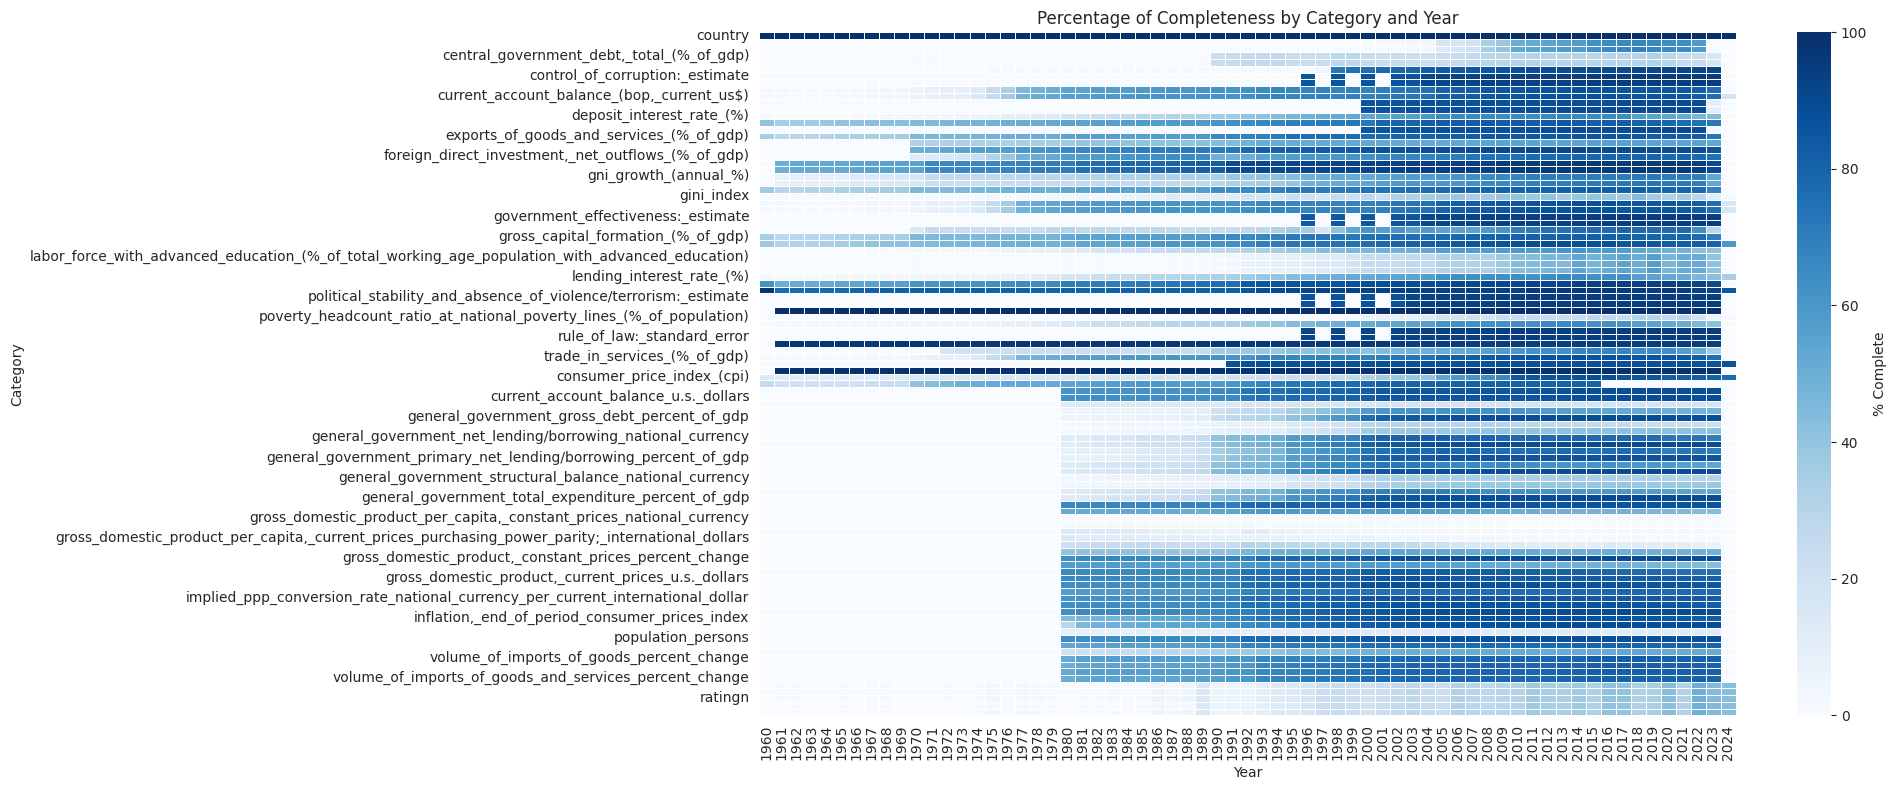

In [18]:
# Check % data completeness per category for all years to decide the period to be removed from data set
rows_per_year = df_final.groupby('year').size()
non_missing_by_year = df_final.groupby('year').count()
percent_complete = (non_missing_by_year.T / rows_per_year).T * 100
percent_complete = percent_complete.apply(pd.to_numeric, errors='coerce')

#Setting plot style
sns.set_style("whitegrid")

plt.figure(figsize=(20, 8))
sns.heatmap(percent_complete.T, cmap="Blues", annot=False, fmt=".1f", linewidths=0.5, cbar_kws={'label': '% Complete'})
plt.title('Percentage of Completeness by Category and Year')
plt.xlabel('Year')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [19]:
# Before year 1980 and for the year 2024 (recent data is not available yet) data is very scarce and we should remove it.
# Filter data only for years between 1980-2023
df_filtered = df_final[df_final['year'].between(1980, 2023)]
df_final = df_filtered.copy()

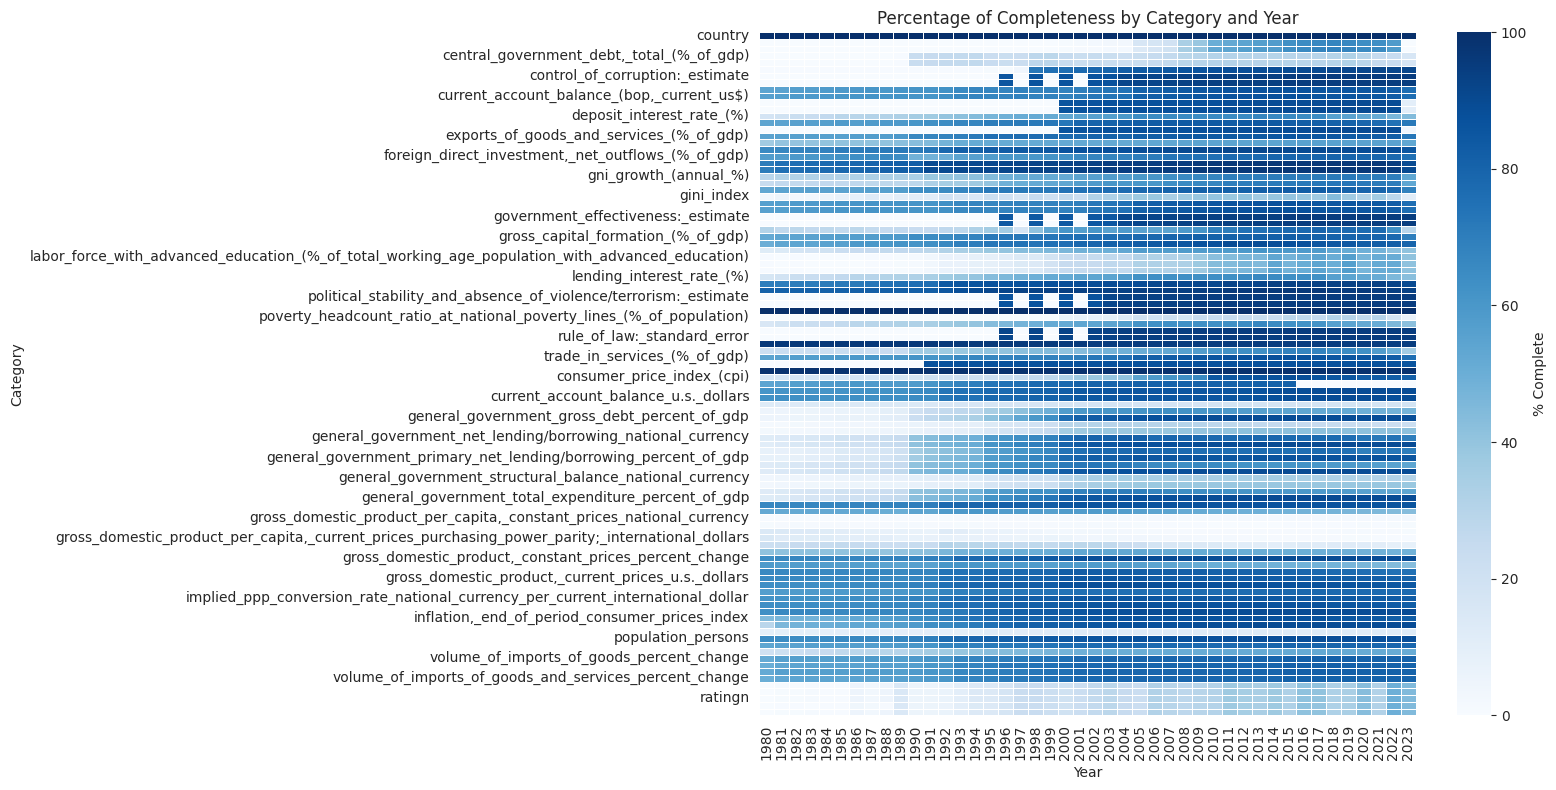

In [20]:
#Check new distribution
rows_per_year = df_final.groupby('year').size()
non_missing_by_year = df_final.groupby('year').count()
percent_complete = (non_missing_by_year.T / rows_per_year).T * 100
percent_complete = percent_complete.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(16, 8))
sns.heatmap(percent_complete.T, cmap="Blues", annot=False, fmt=".1f", linewidths=0.5, cbar_kws={'label': '% Complete'})
plt.title('Percentage of Completeness by Category and Year')
plt.xlabel('Year')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

#### 2.1.3 Cleaning countries that have the most missing values

In [21]:
# Check candidate countries for removal
# 1. Remove countries that have the most missing values e.g. more than 50% of data is missing
# 2. Remove countries for which we don't have any values for the considered output categories 1.ratingn, 2. gross domestic product, constant prices, 
# 3. inflation, average consumer prices, 4. gdp growth (annual %), 5. gdp per capita growth (annual %), 

#============= 1-REMOVE COUNTRIES WITH MOST MISSING VALUES =================

#============ 1.1-Check top 50 countires by missing values =================
# Check percent completeness per country
rows_per_country = df_final.groupby('country').size()
non_missing_by_country = df_final.groupby('country').count()
percent_completeness = (non_missing_by_country.T / rows_per_country).T * 100

# Convert values to numeric
percent_completeness = percent_completeness.apply(pd.to_numeric, errors='coerce')

# Calculate the mean incompleteness for each country
percent_incompleteness = 100 - percent_completeness
percent_incompleteness['mean_incompleteness'] = percent_incompleteness.mean(axis=1)

# Get the list of countries with 50% or more, missing data
countries_to_remove = percent_incompleteness[
    percent_incompleteness['mean_incompleteness'] >= 50
].index.tolist()

# Display the countries to be removed
print('Countries with >= 50% missing data:')
print("="*40)
print(percent_incompleteness[percent_incompleteness['mean_incompleteness'] >= 50]['mean_incompleteness'].sort_values(ascending=False).round(2))
print("="*40)

Countries with >= 50% missing data:
country
St. Martin (French part)     96.66
Gibraltar                    95.50
British Virgin Islands       95.08
Channel Islands              93.74
Northern Mariana Islands     93.27
Sint Maarten (Dutch part)    92.71
Turks and Caicos Islands     92.36
Isle of Man                  91.44
Curacao                      89.75
Guam                         88.99
Virgin Islands (U.S.)        88.97
Liechtenstein                88.93
Monaco                       88.41
Greenland                    88.17
Korea, Dem. People's Rep.    88.12
Cayman Islands               87.19
New Caledonia                87.14
French Polynesia             86.68
Cuba                         80.01
South Sudan                  79.21
Nauru                        76.45
Somalia                      74.60
Sao Tome and Principe        73.55
Andorra                      72.44
Tuvalu                       71.81
Ivory Coast                  71.19
San Marino                   68.56
Kosovo     

In [22]:
#===== 1.2-Remove countries with more than 50% missing data =======

# Set the threshold for exclusion
threshold =  50 # value in percent

# Filter for countries with mean incompleteness higher or equal to threshold
countries_to_remove = percent_incompleteness[percent_incompleteness['mean_incompleteness'] >= threshold].index.tolist()

# Filter df_final to keep only those countries
df_filtered = df_final[~df_final['country'].isin(countries_to_remove)]

df_final = df_filtered.copy()

print('LIST OF REMOVED COUNTRIES')
print("="*112)
print(countries_to_remove)
print("="*112)
print("="*50)
print(f' Total number of countries left: {len(df_final["country"].unique())}')
print("="*50)

LIST OF REMOVED COUNTRIES
['Afghanistan', 'Andorra', 'Aruba', 'British Virgin Islands', 'Cambodia', 'Cayman Islands', 'Channel Islands', 'Cuba', 'Curacao', 'Djibouti', 'Eritrea', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guam', 'Iraq', 'Isle of Man', 'Ivory Coast', 'Kazakhstan', 'Kiribati', "Korea, Dem. People's Rep.", 'Kosovo', 'Laos', 'Liberia', 'Liechtenstein', 'Macau', 'Marshall Islands', 'Micronesia, Fed. Sts.', 'Monaco', 'Montenegro', 'Myanmar', 'Nauru', 'New Caledonia', 'Northern Mariana Islands', 'Palau', 'Puerto Rico', 'San Marino', 'Sao Tome and Principe', 'Serbia', 'Sint Maarten (Dutch part)', 'Somalia', 'South Sudan', 'St. Martin (French part)', 'Syrian Arab Republic', 'Tajikistan', 'Timor-Leste', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Uzbekistan', 'Virgin Islands (U.S.)', 'Yemen, Rep.', 'Zimbabwe']
 Total number of countries left: 161


#### 2.1.4 Cleaning Countries with no ratings

In [23]:
#============= 2-REMOVE COUNTRIES WITH NO RATINGSN =================

# Check countries where all values are missing for ratingn
no_ratingn_countries = (
    df_final.groupby('country')['ratingn']
    .apply(lambda x: x.isna().all())
    .loc[lambda x: x]  # filter only True
    .index.tolist()
)

print(f'Countries with no ratingn at all: {no_ratingn_countries}')


# Drop those countries from the DataFrame
df_final = df_final[~df_final['country'].isin(no_ratingn_countries)]

# Reset index
df_final = df_final.reset_index(drop=True)

print("="*50)
print(f"Removed {len(no_ratingn_countries)} countries with no ratingn at all.")
print("="*50)
print("="*50)
print(f' Total number of countries left: {len(df_final["country"].unique())}')
print("="*50)

Countries with no ratingn at all: ['Algeria', 'Antigua and Barbuda', 'Bhutan', 'Brunei Darussalam', 'Burundi', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Dominica', 'Egypt, Arab Rep.', 'Equatorial Guinea', 'Gambia, The', 'Grenada', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Iran, Islamic Rep.', 'Libya', 'Malawi', 'Mauritania', 'Nepal', 'Samoa', 'Seychelles', 'Sierra Leone', 'Solomon Islands', 'St. Kitts and Nevis', 'St. Lucia', 'Sudan', 'Tonga', 'Vanuatu', 'West Bank and Gaza']
Removed 33 countries with no ratingn at all.
 Total number of countries left: 128


#### 2.1.5 Cleaning categories that are are not needed or/and have too many missing values

In [24]:
# Check categories with 70% or more missing data
df_cat_to_remove = df_final.isna().mean().multiply(100).round(2).sort_values(ascending=False)

# Filter for categories with >= 70% missing values
df_cat_to_remove = df_cat_to_remove[df_cat_to_remove >= 70]

print('======== CATEGORIES WITH >= 70% MISSING DATA ========')
print("="*75)
print(df_cat_to_remove)
print("="*75)

======== CATEGORIES WITH >= 70% MISSING DATA ========
gross_domestic_product_per_capita,_constant_prices_national_currency                                     99.84
gross_domestic_product_per_capita,_constant_prices_purchasing_power_parity;_2021_international_dollar    99.02
gross_domestic_product_per_capita,_current_prices_purchasing_power_parity;_international_dollars         95.31
gross_domestic_product_per_capita,_current_prices_national_currency                                      94.55
poverty_headcount_ratio_at_national_poverty_lines_(%_of_population)                                      83.52
gross_domestic_product_per_capita,_current_prices_u.s._dollars                                           81.82
output_gap_in_percent_of_potential_gdp_percent_of_potential_gdp                                          80.65
employment_persons                                                                                       73.74
general_government_net_debt_national_currency             

In [25]:
# Removing categories with more than 70% missing values
df_cat_to_remove = df_cat_to_remove.index.tolist()
df_filtered = df_final.drop(columns=df_cat_to_remove)
df_final = df_filtered.copy()

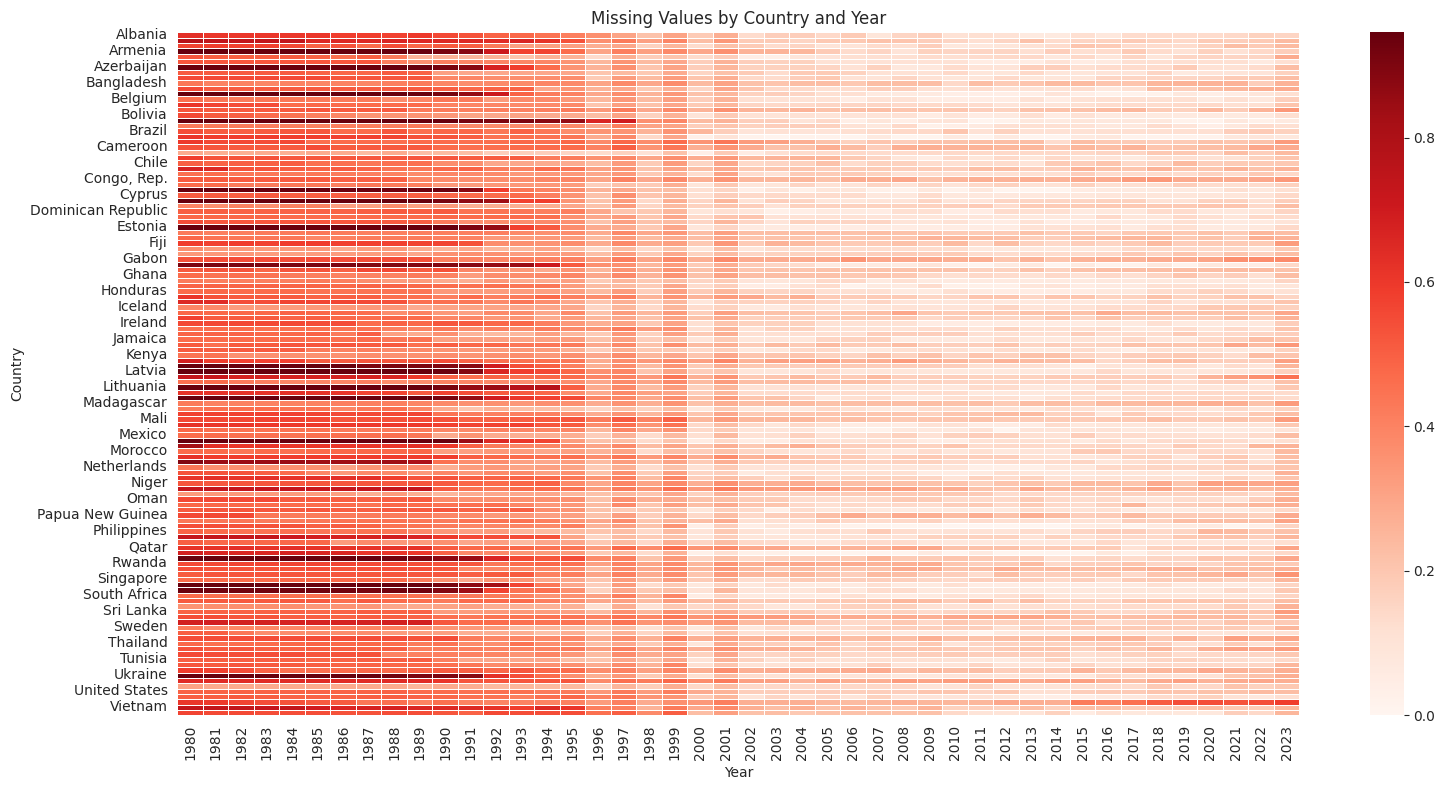

In [26]:
# Check for the missing data using a heatmap
df_final['missing_count'] = df_final.isna().mean(axis=1)
missing_by_country_year = df_final.groupby(['year', 'country'])['missing_count'].sum().reset_index()

heatmap_data = missing_by_country_year.pivot(index='country', columns='year', values='missing_count')

plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, cmap='Reds', annot=False, fmt='.0f', linewidths=0.5)
plt.title('Missing Values by Country and Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

# Drop the missing_count column
df_final.drop(columns='missing_count', inplace=True)

#### 2.1.6 Checking correlations and multicollinearity - Stage I (pre-imputation)

In [27]:
# Calculate the percentage of missing values for each feature

# Define the columns to exclude from the correlation and multicolinearity check
excluded_cols = ['ratingn', 'country', 'year', 
                 'government_effectiveness:_estimate'
                ]

# Create a list of columns that will be included in the correlation check
numerical_cols_to_check = [col for col in df_final.columns if df_final[col].dtype in ['int64', 'float64'] and col not in excluded_cols]

# Create a temporary DataFrame for the correlation check
df_temp = df_final[numerical_cols_to_check]

# Calculate the correlation matrix
corr_matrix = df_temp.corr()

# Create a boolean mask for correlations above the threshold (I have chosen 0.75 as threeshold)
high_corr_mask = (corr_matrix.abs() > 0.75) & (corr_matrix.abs() < 1.0)

# Unstack the matrix to get a list of all highly correlated pairs
high_corr_pairs = high_corr_mask.unstack()

# Filter for the pairs that are True
filtered_multicollinear_features = high_corr_pairs[high_corr_pairs].index.tolist()

missing_values_percent = df_temp.isnull().mean()

# Identify features to drop based on the missing values rule
features_to_drop = set()
checked_pairs = set()

print("=" * 150)
print("Analyzing Multicollinear Pairs for Missing Values:")
print("-" * 50)

for pair in filtered_multicollinear_features:
    # Ensure the pair hasn't been processed in a different order
    if tuple(sorted(pair)) in checked_pairs:
        continue
    
    # Get the missing value percentage for each feature in the pair
    feat1, feat2 = pair
    mv1 = missing_values_percent[feat1]
    mv2 = missing_values_percent[feat2]
    
    # Apply the rule: keep the feature with fewer missing values
    if mv1 > mv2:
        features_to_drop.add(feat1)
        print(f"Pair: ({feat1}, vs. {feat2}) | Missing Values: {mv1:.2%} vs {mv2:.2%}")
        print(f"-> Discarding '{feat1}'")
    elif mv2 > mv1:
        features_to_drop.add(feat2)
        print(f"Pair: ({feat1}, vs. {feat2}) | Missing Values: {mv1:.2%} vs {mv2:.2%}")
        print(f"-> Discarding '{feat2}'")
    else:
        # If missing values are equal, I will keep the one that comes first in the list
        print(f"Pair: ({feat1},  vs. {feat2}) | Missing Values are equal ({mv1:.2%})")
        
    checked_pairs.add(tuple(sorted(pair)))

print("=" * 112)
print("Final list of features to discard due to high multicollinearity and high missing values:")
print("=" * 112)
print(list(features_to_drop))
print("=" * 112)

Analyzing Multicollinear Pairs for Missing Values:
--------------------------------------------------
Pair: (central_government_debt,_total_(%_of_gdp), vs. gross_debt,_general_government,_percent_of_fiscal_year_gdp) | Missing Values: 69.53% vs 27.50%
-> Discarding 'central_government_debt,_total_(%_of_gdp)'
Pair: (central_government_debt,_total_(%_of_gdp), vs. general_government_gross_debt_percent_of_gdp) | Missing Values: 69.53% vs 31.75%
-> Discarding 'central_government_debt,_total_(%_of_gdp)'
Pair: (central_government_debt,_total_(%_of_gdp), vs. general_government_net_debt_percent_of_gdp) | Missing Values: 69.53% vs 62.78%
-> Discarding 'central_government_debt,_total_(%_of_gdp)'
Pair: (control_of_corruption:_estimate, vs. political_stability_and_absence_of_violence/terrorism:_estimate) | Missing Values: 43.27% vs 43.18%
-> Discarding 'control_of_corruption:_estimate'
Pair: (control_of_corruption:_estimate, vs. rule_of_law:_estimate) | Missing Values: 43.27% vs 43.18%
-> Discarding

#### 2.1.7 Drop unwanted columns

In [28]:
df_final.drop(columns=features_to_drop, inplace=True)

In [29]:
# Drop columns that are not relevant or shows multicolinearity
columns_to_drop = ['agency', 'rating', 'date',
                   'urban_population_growth_(annual_%)',
                   'rule_of_law:_estimate', 'goods_exports_(bop,_current_us$)', 'government_effectiveness:_standard_error', 'political_stability_and_absence_of_violence/terrorism:_standard_error'
                  ]

# Drop the columns
df_final.drop(columns=columns_to_drop, inplace=True)

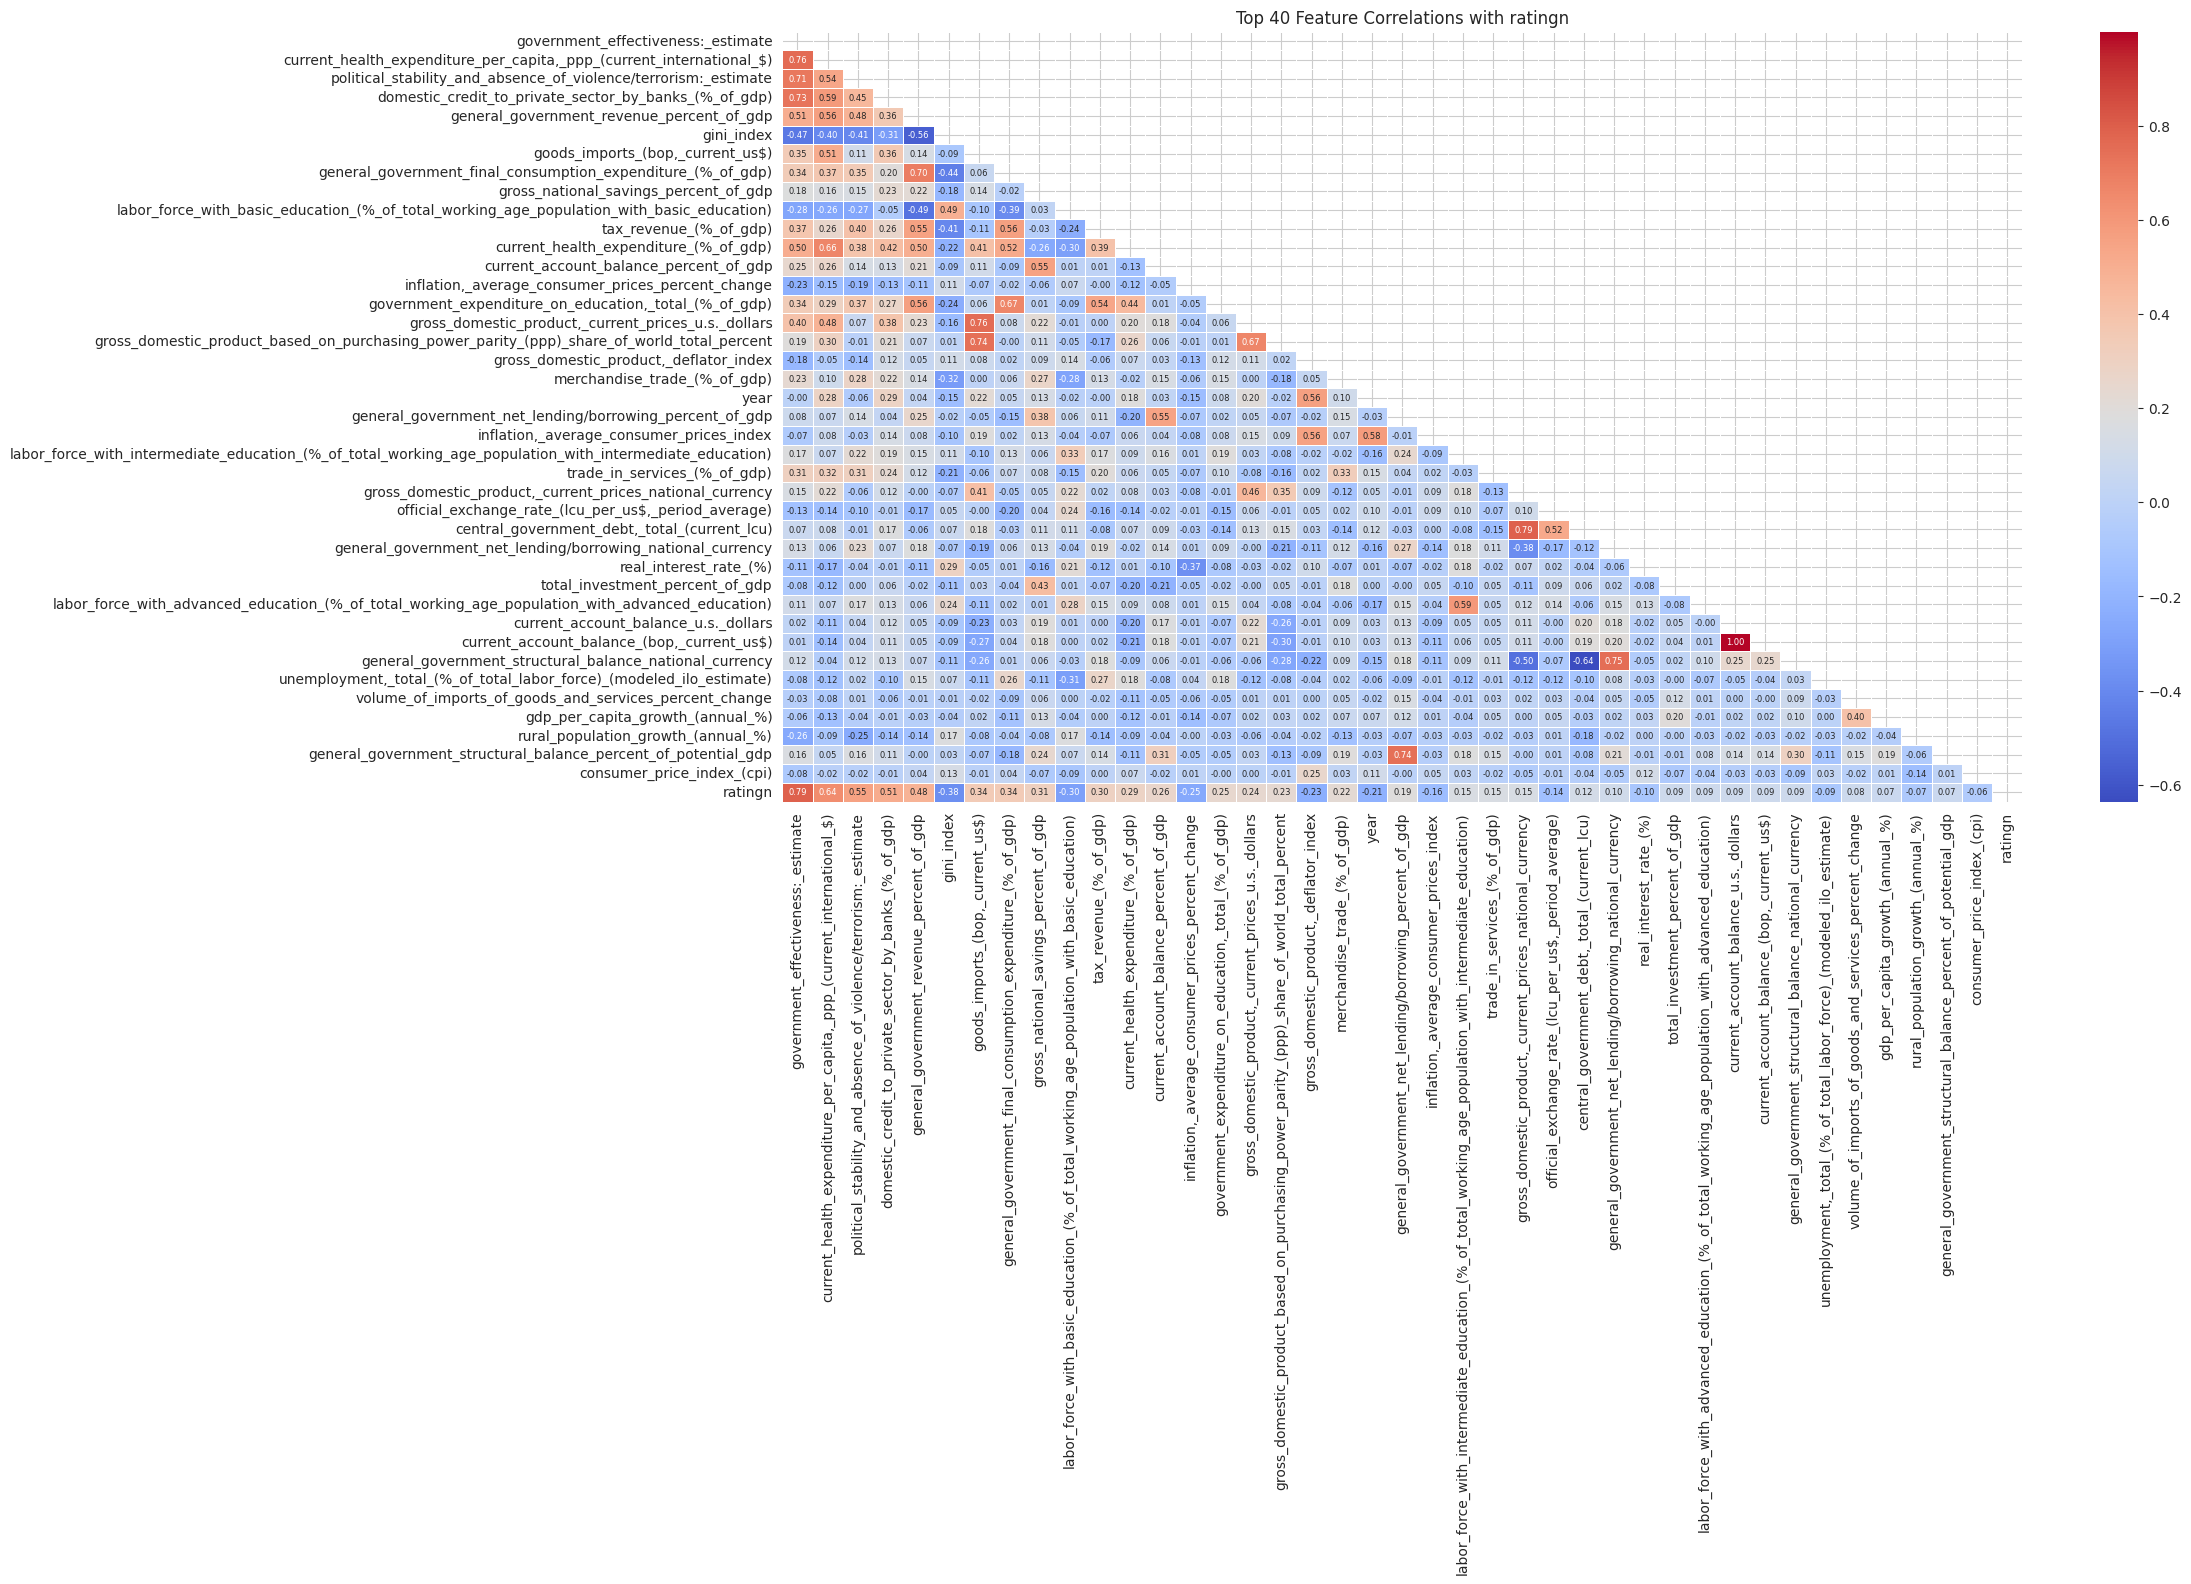

In [30]:
# Checking corelation with 'ratingn' for the top features
corr_matrix = df_final.corr(numeric_only=True)
target_corr = corr_matrix['ratingn'].abs().sort_values(ascending=False)

# Select the top 40 most correlated features to focus on
top_features = target_corr[1:41].index.tolist()

# Create a new DataFrame with only these features plus the target
df_subset = df_final[top_features + ['ratingn']]

# Plot the heatmap for the subset
plt.figure(figsize=(20, 10))
mask = np.triu(np.ones_like(df_subset.corr(), dtype=bool))
sns.heatmap(df_subset.corr(numeric_only=True), mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 6})
plt.title('Top 40 Feature Correlations with ratingn')
plt.show()

#### 2.1.8 Analyze and process outliers

In [31]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

# Explore dataset
df_final.describe()

year  central_government_debt,_total_(current_lcu)  \
count  5632.000000                                        1716.0   
mean   2001.500000                         31067096462600.386719   
std      12.699553                            152961377035155.25   
min    1980.000000                                        2370.0   
25%    1990.750000                                 16664027500.0   
50%    2001.500000                                210500000000.0   
75%    2012.250000                               1532500000000.0   
max    2023.000000                            1690000000000000.0   

       compulsory_education,_duration_(years)  \
count                                  3075.0   
mean                                 9.709919   
std                                  2.262768   
min                                       4.0   
25%                                       9.0   
50%                                      10.0   
75%                                      11.0   
max                                      17.0   

       current_account_balance_(bop,_current_us$)  \
count                                      4961.0   
mean                              71936370.226164   
std                            51581678821.414307   
min                              -1010000000000.0   
25%                                 -1718091086.0   
50%                                  -293768116.0   
75%                                   416000022.0   
max                                443000000000.0   

       current_health_expenditure_(%_of_gdp)  \
count                            2922.000000   
mean                                6.337761   
std                                 2.569621   
min                                 1.505008   
25%                                 4.319468   
50%                                 6.148428   
75%                                 8.097602   
max                                21.969868   

       current_health_expenditure_per_capita,_ppp_(current_international_$)  \
count                                             2921.0                      
mean                                         1522.753167                      
std                                          1775.161613                      
min                                                 10.0                      
25%                                                281.0                      
50%                                                812.0                      
75%                                               2174.0                      
max                                              12434.0                      

       deposit_interest_rate_(%)  \
count                3243.000000   
mean                   60.626986   
std                  2304.628377   
min                    -0.418531   
25%                     3.490417   
50%                     6.500000   
75%                    10.647917   
max                130591.969600   

       domestic_credit_to_private_sector_by_banks_(%_of_gdp)  \
count                                        4789.000000       
mean                                           46.469059       
std                                            39.675032       
min                                             0.000000       
25%                                            17.955511       
50%                                            33.999955       
75%                                            61.841920       
max                                           304.575113       

       foreign_direct_investment,_net_inflows_(%_of_gdp)  \
count                                        5311.000000   
mean                                            4.231686   
std                                            20.495998   
min                                          -440.130675   
25%                                             0.584255   
50%                                             1.929218   
75%           

In [32]:
pd.reset_option('display.max_columns')

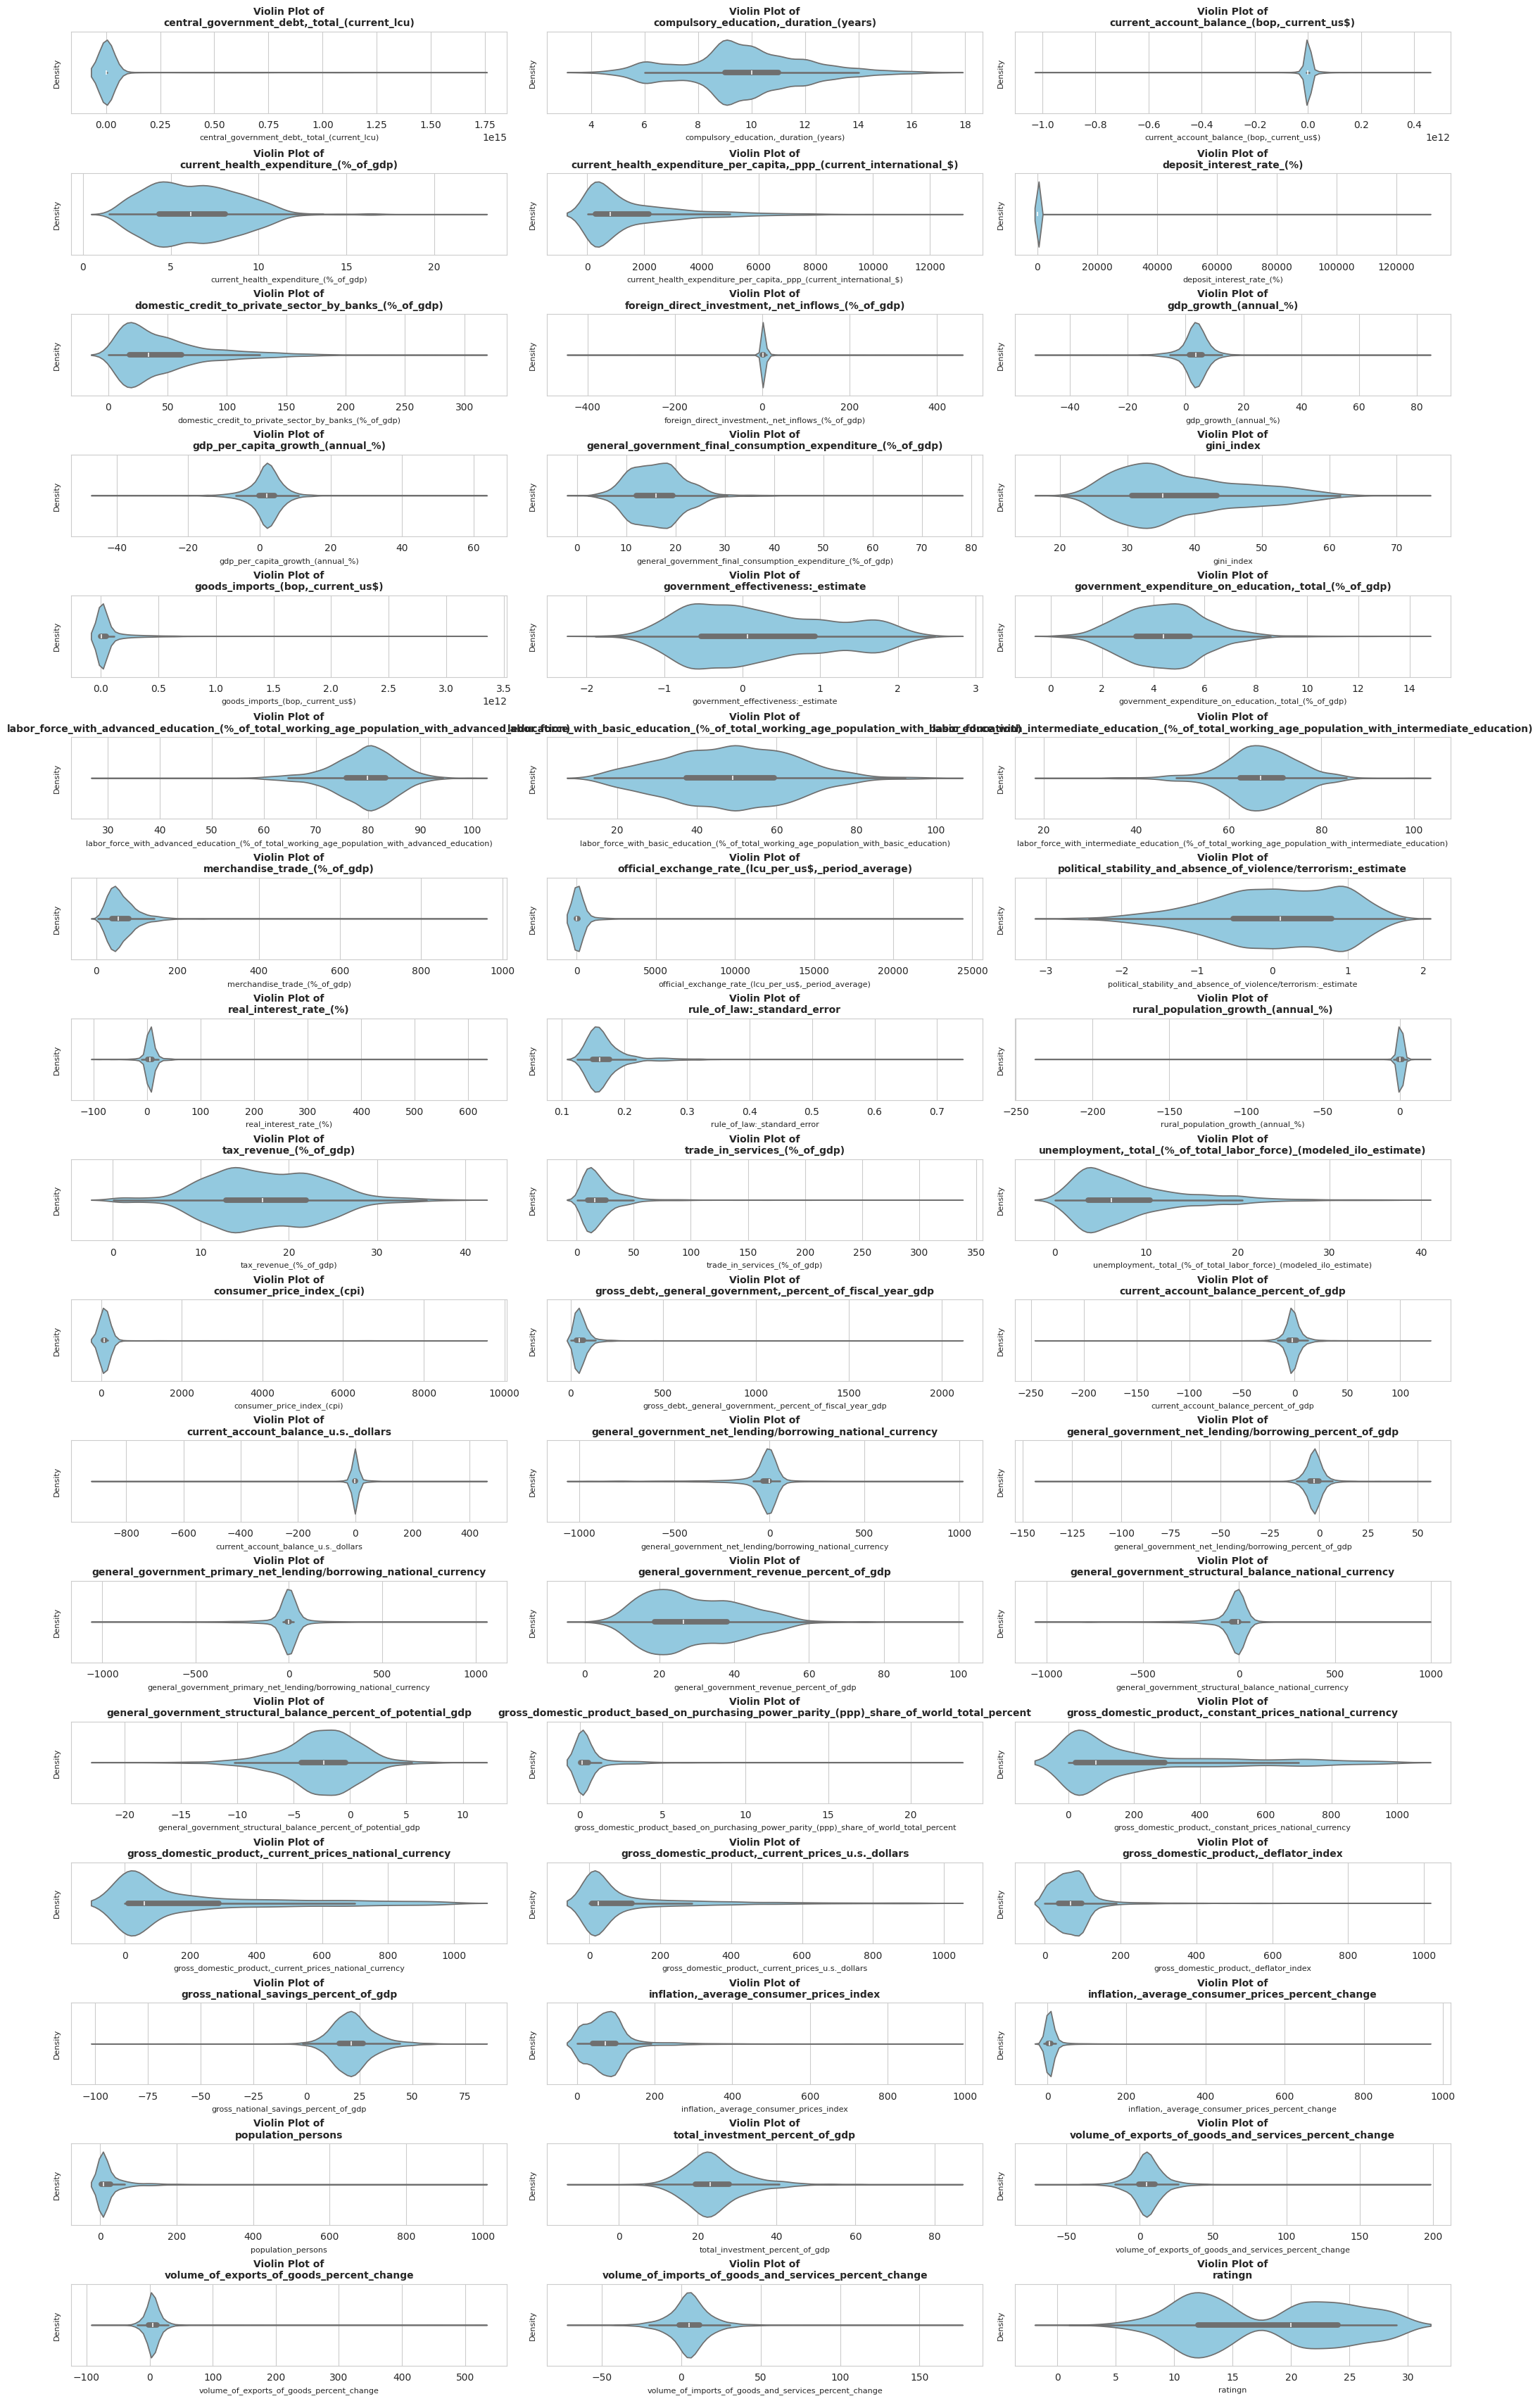

In [33]:
# Visualized the distributions of all numerical columns to check for outliers
# Select all numerical columns
numerical_columns = df_final.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Determine the number of subplots
num_cols = 3  # Number of columns for the grid
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

# Creating the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 2 * num_rows), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loopping through each numerical column to create a violin plot
for i, col in enumerate(numerical_columns):
    sns.violinplot(x=df_final[col], ax=axes[i], legend=False, color='skyblue')
    wrapped_title = f'Violin Plot of\n{col}'
    axes[i].set_title(wrapped_title, fontsize=10, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Density', fontsize=8)

# Hide any unused subplots
for i in range(len(numerical_columns), len(axes)):
    axes[i].axis('off')

# Save the plots to a file
plt.savefig("data/violin_plots.png")
plt.show();

##### Process outliers - No outliers identified - (might be revisited later only if required)

### 2.2 Imputation for missing data

#### 2.2.1 Inputation for missing country's ratings (Target columns)

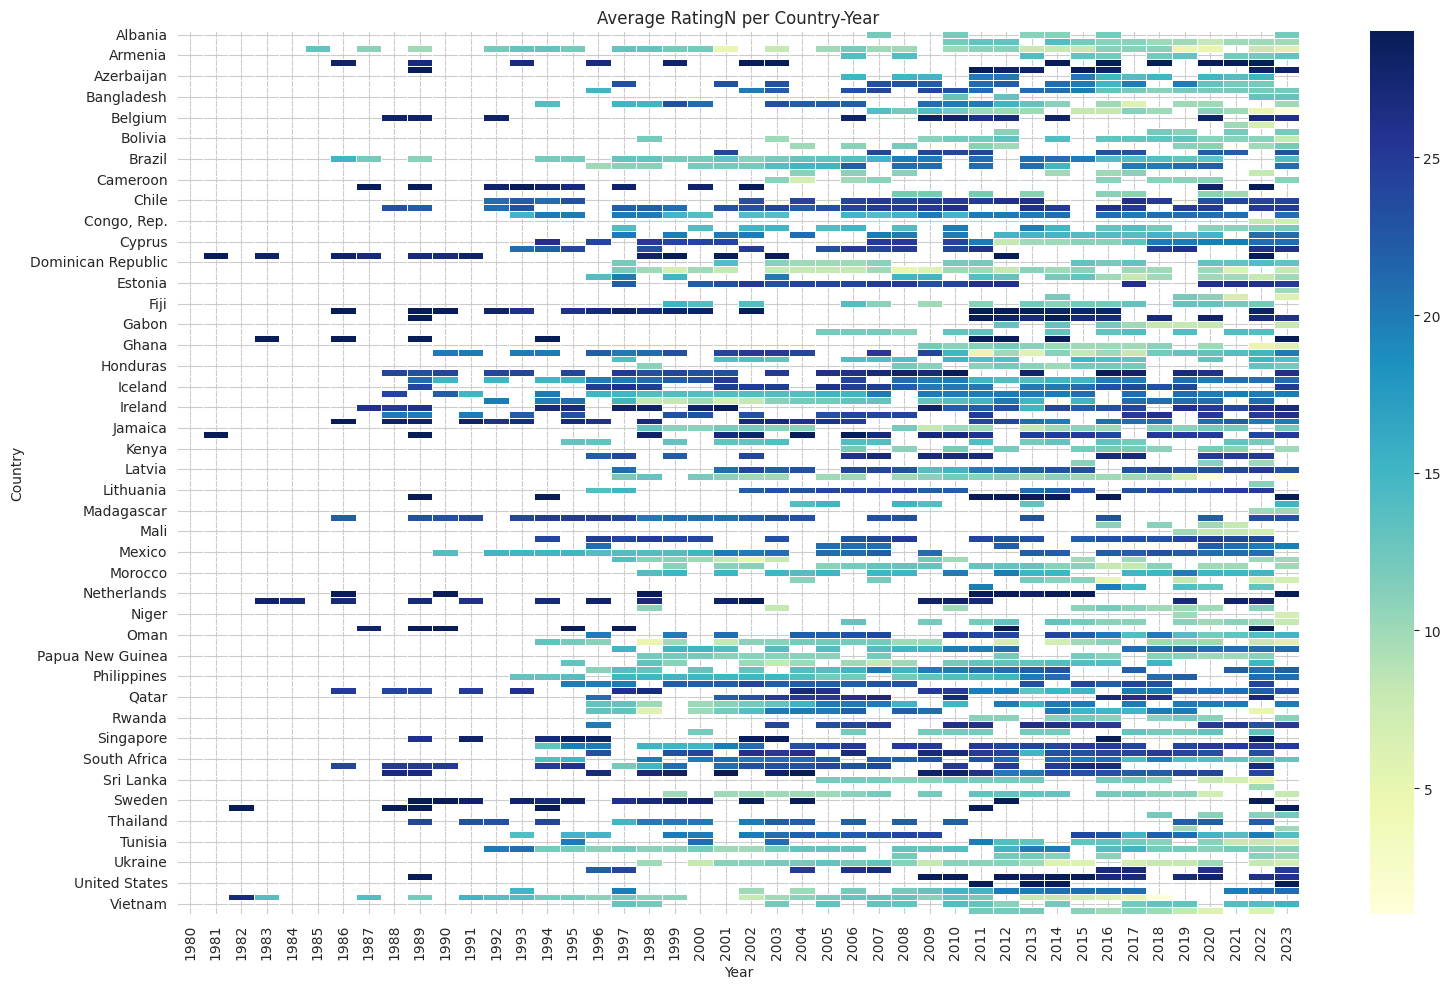

In [34]:
# Check distribution of rating by country and by year to assess the imputation technique for ratingn and outlookrank
# Compute the mean
dfx = df_final.groupby(['country', 'year'])['ratingn'].mean().unstack()
dfx = dfx.astype(float)

# Plot on heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(dfx, cmap='YlGnBu', annot=False, fmt='.1f', linewidths=0.5)
plt.title('Average RatingN per Country-Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [35]:
# Check distriburion of rankingn across classes

print("="*50)
print('Distribution of rankingn labels across classes')
print("="*50)
print(df_final['ratingn'].value_counts())
print("="*50)

Distribution of rankingn labels across classes
ratingn
12    177
11    163
20    152
10    132
13    130
15    126
21    115
14    113
24    111
25    102
23    101
29    100
22     86
27     70
28     68
26     61
8      59
7      19
6      14
5      13
1       4
Name: count, dtype: Int64


In [36]:
# Check distriburion of outlook labels across classes

print("="*50)
print('Distribution of labels across classes')
print("="*50)
print(df_final['outlook'].value_counts())
print("="*50)


Distribution of labels across classes
outlook
Stable            1138
Negative           384
Positive           309
Negative Watch      43
Under Review        11
Positive Watch       8
Name: count, dtype: int64


In [37]:
# Combine classes by renaming "Watch" classes into their core class and "Under Review" replaced with majority class "Stable" 
df_final['outlook'] = df_final['outlook'].replace({
    'Negative Watch': 'Negative',
    'Positive Watch': 'Positive',
    'Under Review': 'Stable'
})

In [38]:
print("="*50)
print('Distribution of outlook labels across classes')
print("="*50)
print(df_final['outlook'].value_counts())
print("="*50)

Distribution of outlook labels across classes
outlook
Stable      1149
Negative     427
Positive     317
Name: count, dtype: int64


In [39]:
# Imputation for ratingn should be in two stages: 
#1. Forward fill - fill in forward most of the missing values
#2. Backward fill - fill-in the missing values before the first available record

print("="*50)
print('Number of missing rating or outlook before imputation:')
print(df_final[['ratingn', 'outlook']].isna().sum());
print("="*50)
# Two-stage imputation by country
df_final[['ratingn', 'outlook']] = (
    df_final
    .sort_values(['country', 'year'])  # ensure chronological order
    .groupby('country')[['ratingn', 'outlook']]
    .transform(lambda x: x.ffill().bfill())
)

# Count remaining missing values
print("="*50)
print('Total number of countries without rating or outlook:')
print("="*50)
print(df_final[['ratingn', 'outlook']].isna().sum());
print("="*50)

Number of missing rating or outlook before imputation:
ratingn    3716
outlook    3739
dtype: int64
Total number of countries without rating or outlook:
ratingn    0
outlook    0
dtype: int64


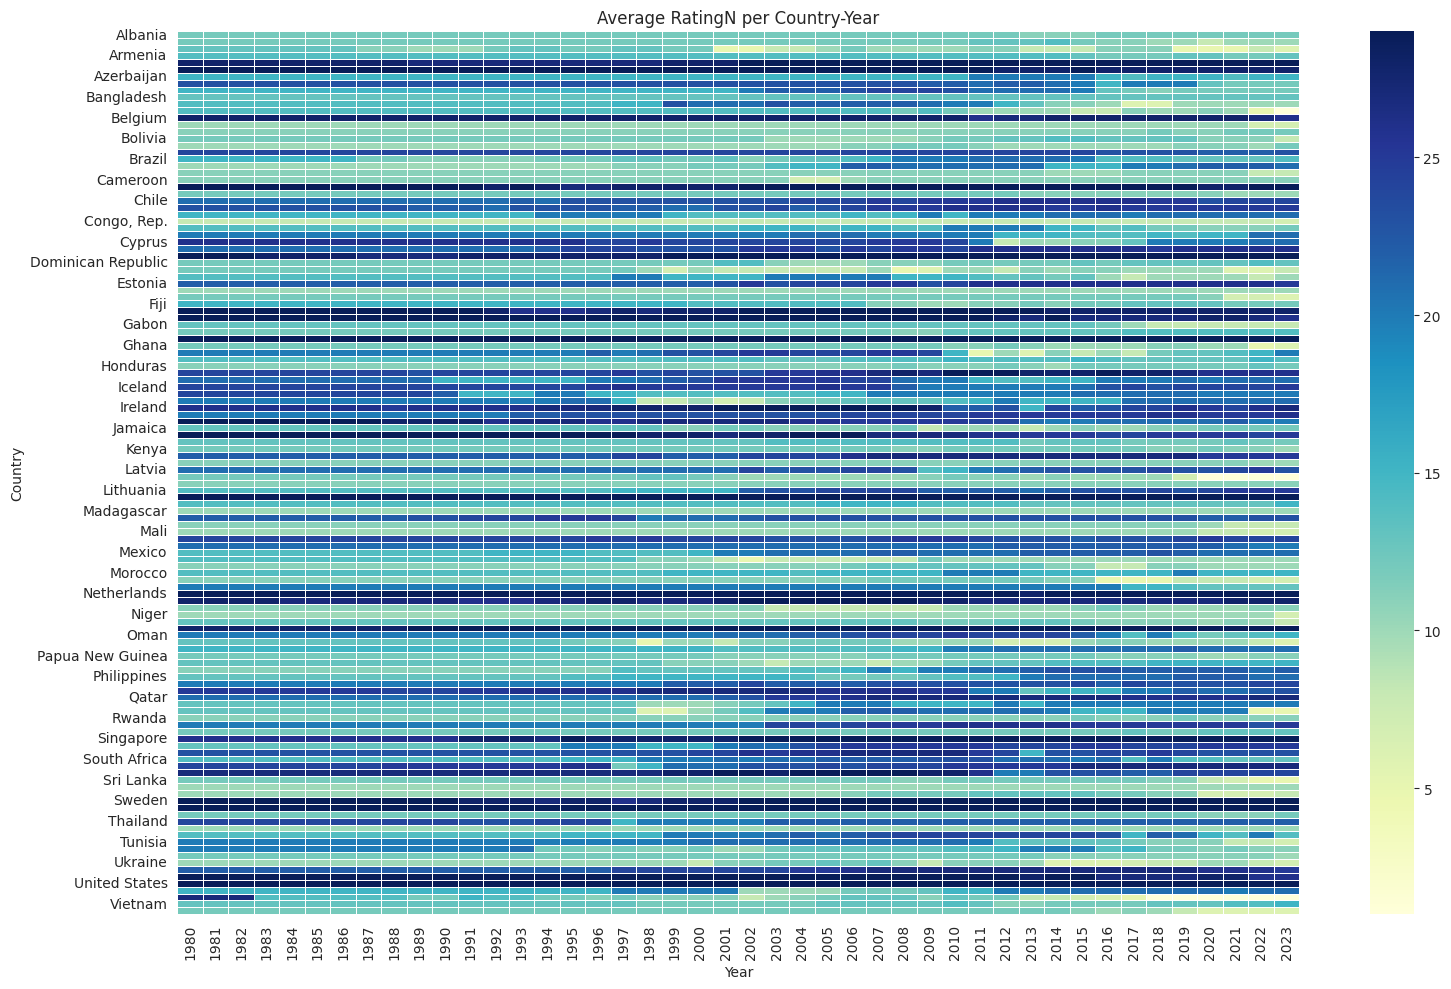

In [40]:
# Check distribution of rating by country and by year to assess the imputation technique
# Compute the mean
#dfx = df_final.groupby(['country', 'year'])['ratingn'].mean().unstack()
dfx = df_final.pivot(index='country', columns='year', values='ratingn')
dfx = dfx.astype(int)

# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(dfx, cmap='YlGnBu', annot=False, linewidths=0.5)
plt.title('Average RatingN per Country-Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

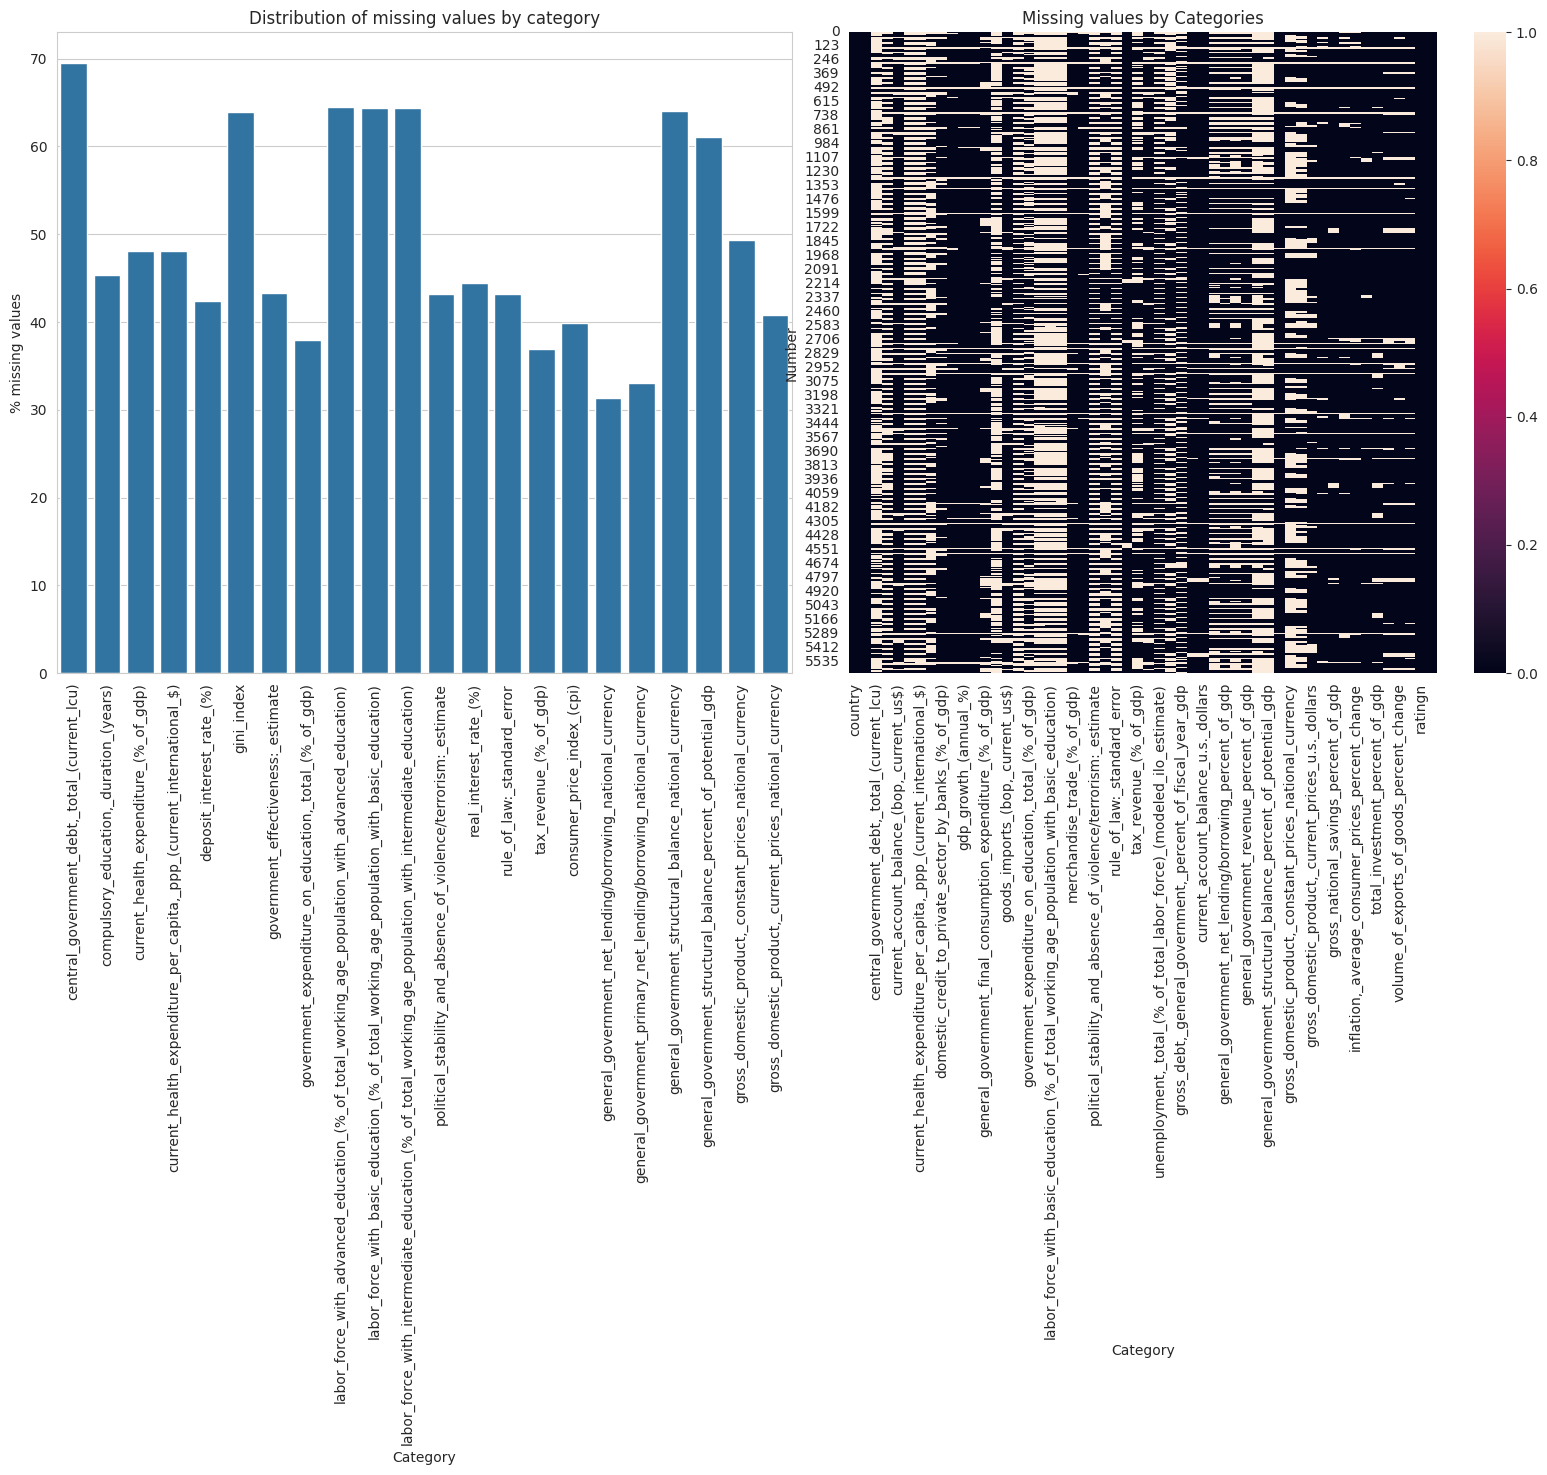

In [41]:
#Check missing values for each category and their distribution

missing_val = df_final.isna().mean().multiply(100).round(2)
missing_val_over60 = missing_val[missing_val >= 30]

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
plt.tight_layout()

sns.barplot(data=missing_val_over60, ax=axes[0])
axes[0].set_title('Distribution of missing values by category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('% missing values')
axes[0].tick_params(axis='x', rotation=90)

sns.heatmap(data=df_final.isna(), ax=axes[1])
axes[1].set_title('Missing values by Categories')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Number');

#### 2.2.3 Imputation for mising data in the rest of the columns (Features columns)

In [42]:
# Get the list of columns with NaNs for each country
all_nan_columns_by_country = (
    df_final
    .drop(columns=['country', 'year'])  # Exclude non-data columns
    .groupby(df_final['country'])
    .apply(lambda x: x.columns[x.isna().all()].tolist())
)

# Filter for countries that have at least one column with all NaNs
countries_with_all_nan_cols = all_nan_columns_by_country[all_nan_columns_by_country.apply(len) > 0]

# Flatten the lists of columns and get unique values
all_unique_empty_columns = set(
    [col for sublist in countries_with_all_nan_cols for col in sublist]
)

print("Unique columns with all NaNs across any country:")
print("="*110)
print(list(all_unique_empty_columns))
print("="*110)

Unique columns with all NaNs across any country:
['consumer_price_index_(cpi)', 'gini_index', 'general_government_primary_net_lending/borrowing_national_currency', 'volume_of_imports_of_goods_and_services_percent_change', 'gross_domestic_product,_current_prices_u.s._dollars', 'gross_national_savings_percent_of_gdp', 'volume_of_exports_of_goods_and_services_percent_change', 'gross_domestic_product,_constant_prices_national_currency', 'compulsory_education,_duration_(years)', 'general_government_final_consumption_expenditure_(%_of_gdp)', 'trade_in_services_(%_of_gdp)', 'general_government_structural_balance_percent_of_potential_gdp', 'real_interest_rate_(%)', 'gross_domestic_product,_current_prices_national_currency', 'labor_force_with_advanced_education_(%_of_total_working_age_population_with_advanced_education)', 'rural_population_growth_(annual_%)', 'current_health_expenditure_(%_of_gdp)', 'tax_revenue_(%_of_gdp)', 'current_health_expenditure_per_capita,_ppp_(current_international_$)'

In [43]:
# Checking for columns that have only NaNs to the entire serie
print("Distribution of NaNs across different features:")
print("="*112)
print(df_final.isna().mean().multiply(100).sort_values(ascending=False).round(2).head(10))
print("="*112)

Distribution of NaNs across different features:
central_government_debt,_total_(current_lcu)                                                               69.53
labor_force_with_advanced_education_(%_of_total_working_age_population_with_advanced_education)            64.51
labor_force_with_basic_education_(%_of_total_working_age_population_with_basic_education)                  64.38
labor_force_with_intermediate_education_(%_of_total_working_age_population_with_intermediate_education)    64.38
general_government_structural_balance_national_currency                                                    64.08
gini_index                                                                                                 63.96
general_government_structural_balance_percent_of_potential_gdp                                             61.08
gross_domestic_product,_constant_prices_national_currency                                                  49.29
current_health_expenditure_per_capita,_ppp_(curr

In [44]:
# ================================================
# Define Imputation Strategy for each column
# ================================================

poly_interpolate_cols = ['compulsory_education,_duration_(years)',
       'current_account_balance_(bop,_current_us$)',
       'current_health_expenditure_(%_of_gdp)',
       'current_health_expenditure_per_capita,_ppp_(current_international_$)',
       'deposit_interest_rate_(%)',
       'domestic_credit_to_private_sector_by_banks_(%_of_gdp)',
       'foreign_direct_investment,_net_inflows_(%_of_gdp)', 
       'gdp_per_capita_growth_(annual_%)',
       'general_government_final_consumption_expenditure_(%_of_gdp)',
       'gini_index', 'goods_imports_(bop,_current_us$)',
       'government_effectiveness:_estimate',
       'government_expenditure_on_education,_total_(%_of_gdp)',
       'labor_force_with_advanced_education_(%_of_total_working_age_population_with_advanced_education)',
       'labor_force_with_basic_education_(%_of_total_working_age_population_with_basic_education)',
       'labor_force_with_intermediate_education_(%_of_total_working_age_population_with_intermediate_education)',
       'merchandise_trade_(%_of_gdp)',
       'official_exchange_rate_(lcu_per_us$,_period_average)',
       'political_stability_and_absence_of_violence/terrorism:_estimate',
       'real_interest_rate_(%)',
       'rural_population_growth_(annual_%)', 'tax_revenue_(%_of_gdp)',
       'trade_in_services_(%_of_gdp)',
       'consumer_price_index_(cpi)',
       'gross_debt,_general_government,_percent_of_fiscal_year_gdp',
       'current_account_balance_percent_of_gdp',
       'current_account_balance_u.s._dollars',
       'general_government_net_lending/borrowing_national_currency',
       'general_government_net_lending/borrowing_percent_of_gdp',
       'general_government_primary_net_lending/borrowing_national_currency',
       'general_government_revenue_percent_of_gdp',
       'general_government_structural_balance_percent_of_potential_gdp',
       'gross_domestic_product_based_on_purchasing_power_parity_(ppp)_share_of_world_total_percent',
       'gross_domestic_product,_constant_prices_national_currency',
       'gross_domestic_product,_current_prices_national_currency',
       'gross_domestic_product,_current_prices_u.s._dollars',
       'gross_domestic_product,_deflator_index',
       'gross_national_savings_percent_of_gdp',
       'inflation,_average_consumer_prices_index',
       'inflation,_average_consumer_prices_percent_change',
       'population_persons', 'total_investment_percent_of_gdp',
       'volume_of_exports_of_goods_and_services_percent_change',
       'volume_of_exports_of_goods_percent_change']

ffill_bfill_cols = ['compulsory_education,_duration_(years)']
mean_fill_cols = []
rolling_avg_cols = []
arima_cols = ['gdp_growth_(annual_%)', 'unemployment,_total_(%_of_total_labor_force)_(modeled_ilo_estimate)']

# ================================================
# Imputation Helper Functions
# ================================================

def smart_interpolate(series, order=2):
    min_points = order + 1
    if series.notna().sum() >= min_points:
        return series.interpolate(method='polynomial', order=order)
    else:
        return series.interpolate(method='linear', limit_direction='both')

def impute_with_arima(series):
    s = series.copy()
    if s.isnull().all() or s.notna().sum() < 3:
        return s.interpolate(method='linear', limit_direction='both')
    try:
        model = ARIMA(s.dropna(), order=(0, 1, 1))
        model_fit = model.fit()
        forecast = model_fit.predict(start=s.index[0], end=s.index[-1])
        s[s.isna()] = forecast[s.isna()]
        return s
    except Exception:
        return s.interpolate(method='linear', limit_direction='both')

# ================================================
# Main Imputation Pipeline
# ================================================

def run_staged_imputation(df, poly_cols, ffill_cols, mean_cols, arima_cols):
    df_imputed = df.copy().sort_values(['country', 'year'])
    imputation_log = {
        'sparse_imputation': 0,
        'poly_or_linear': 0,
        'ffill_bfill': 0,
        'mean': 0,
        'arima': 0,
        'global_fallback': 0
    }

    all_imputation_cols = list(set(poly_cols + ffill_cols + arima_cols + mean_cols))
    for col in all_imputation_cols:
        if col in df_imputed.columns and pd.api.types.is_numeric_dtype(df_imputed[col]):
            df_imputed[col] = df_imputed[col].astype('float64')

    # Initial check of missing values
    initial_total_missing = df_imputed.isnull().sum().sum()

    # Stage 1: Impute series with only NaNs with global median
    all_nan_columns_by_country = df_imputed.groupby('country').apply(
        lambda x: x.columns[x.isna().all()].tolist()
    )
    for country, empty_cols in all_nan_columns_by_country.items():
        if empty_cols:
            for col in empty_cols:
                if col in all_imputation_cols:
                    median_val = df_imputed[col].median()
                    # Use loc for specific and safe assignment
                    df_imputed.loc[df_imputed['country'] == country, col] = df_imputed.loc[df_imputed['country'] == country, col].fillna(median_val)
    imputation_log['sparse_imputation'] = initial_total_missing - df_imputed.isnull().sum().sum()

    # Stage 2: Impute with Polynomial/Linear Interpolation
    missing_before = df_imputed.isnull().sum().sum()
    if poly_cols:
        df_imputed[poly_cols] = df_imputed.groupby('country')[poly_cols].transform(smart_interpolate)
    imputation_log['poly_or_linear'] = missing_before - df_imputed.isnull().sum().sum()

    # Stage 3: Impute with Forward/Backward Fill
    missing_before = df_imputed.isnull().sum().sum()
    if ffill_cols:
        df_imputed[ffill_cols] = df_imputed.groupby('country')[ffill_cols].transform(lambda x: x.ffill().bfill())
    imputation_log['ffill_bfill'] = missing_before - df_imputed.isnull().sum().sum()

    # Stage 4: Impute with Mean
    missing_before = df_imputed.isnull().sum().sum()
    if mean_cols:
        for col in mean_cols:
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())
    imputation_log['mean'] = missing_before - df_imputed.isnull().sum().sum()

    # Stage 5: Impute with ARIMA
    missing_before = df_imputed.isnull().sum().sum()
    if arima_cols:
        for col in arima_cols:
            df_imputed[col] = df_imputed.groupby('country')[col].transform(impute_with_arima)
    imputation_log['arima'] = missing_before - df_imputed.isnull().sum().sum()
    
    # Stage 6: Global Fallback for any remaining NaNs
    missing_before = df_imputed.isnull().sum().sum()
    for col in df_imputed.columns:
        if df_imputed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_imputed[col]):
                median_int = int(df_imputed[col].median())
                df_imputed[col] = df_imputed[col].fillna(median_int)
            else:
                mode_val = df_imputed[col].mode()[0]
                df_imputed[col] = df_imputed[col].fillna(mode_val)
    imputation_log['global_fallback'] = missing_before - df_imputed.isnull().sum().sum()

    return df_imputed, imputation_log

df_final_imputed, imputation_log_results = run_staged_imputation(df_final, poly_interpolate_cols, ffill_bfill_cols, mean_fill_cols, arima_cols)

print("="*112)
print(imputation_log_results)
print("="*112)

{'sparse_imputation': np.int64(10252), 'poly_or_linear': np.int64(7108), 'ffill_bfill': np.int64(2336), 'mean': np.int64(0), 'arima': np.int64(1635), 'global_fallback': np.int64(55986)}


In [45]:
# Copy the dataframe into the working DataFrame
dfc = df_final_imputed.copy()

## 3. Modeling

### 3.1 Features Engineering

#### 3.1.1 PCA Analysis

In [46]:
# Separate imputs from targets
X_features = dfc.drop(columns=['ratingn', 'outlook']).copy()
y_targets = dfc[['ratingn', 'outlook']].copy()

# Select columns by type from the features DataFrame
numerical_columns = X_features.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
categorical_columns = X_features.select_dtypes(include=['object', 'int32']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X_features)

# Convert X_processed to dense array if it's sparse
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

# Get the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame
df_preprocessed = pd.DataFrame(X_processed, columns=feature_names)

# Create the new preprocessed DataFrame with the new column names
df_preprocessed = pd.DataFrame(X_processed, columns=feature_names)

# Clean the column names in the new DataFrame
df_preprocessed.columns = df_preprocessed.columns.str.replace('num__', '', regex=False)
df_preprocessed.columns = df_preprocessed.columns.str.replace('cat__', '', regex=False)
df_preprocessed.columns = df_preprocessed.columns.str.replace('remainder__', '', regex=False)


# Run PCA on the preprocessed DataFrame
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df_preprocessed)

# Get the first principal component's feature contributions
top_features = pd.Series(pca.components_[0], index=df_preprocessed.columns).sort_values(ascending=False)

# Filter the column of interest
filtered_features = top_features[(top_features >= 0.01) & (top_features < 0.99)]

# Display the top features for the first principal component
print("="*120)
print("Top features for the first principal component:")
print("="*112)
print(filtered_features)
print("="*112)

# Get the list of PCA-filtered feature names
pca_features_list = filtered_features.index.to_list()

Top features for the first principal component:
current_health_expenditure_per_capita,_ppp_(current_international_$)                                       0.347278
government_effectiveness:_estimate                                                                         0.345317
general_government_revenue_percent_of_gdp                                                                  0.304881
domestic_credit_to_private_sector_by_banks_(%_of_gdp)                                                      0.291613
current_health_expenditure_(%_of_gdp)                                                                      0.283343
political_stability_and_absence_of_violence/terrorism:_estimate                                            0.274317
government_expenditure_on_education,_total_(%_of_gdp)                                                      0.225201
general_government_final_consumption_expenditure_(%_of_gdp)                                                0.223305
tax_revenue_(%_of_gdp)  

In [47]:
# Create a list of columns to keep from your original DataFrame
# These are the columns I want to join back
original_columns_to_keep = ['country', 'ratingn', 'outlook']

# Select only the features you want from the PREPROCESSED DataFrame
df_pca_filtered = df_preprocessed[pca_features_list]

# Reset the index of the original DataFrame to ensure a clean merge
df_original_with_index = dfc.reset_index(drop=True)

# Join the original columns with the filtered PCA features
df_filtered = pd.concat([df_original_with_index[original_columns_to_keep], df_pca_filtered], axis=1)

In [48]:
# Update the working df
dfc = df_filtered.copy()

#### 3.2.1 Correlations and multi-colinearity per target - Stage II (post-imputation)

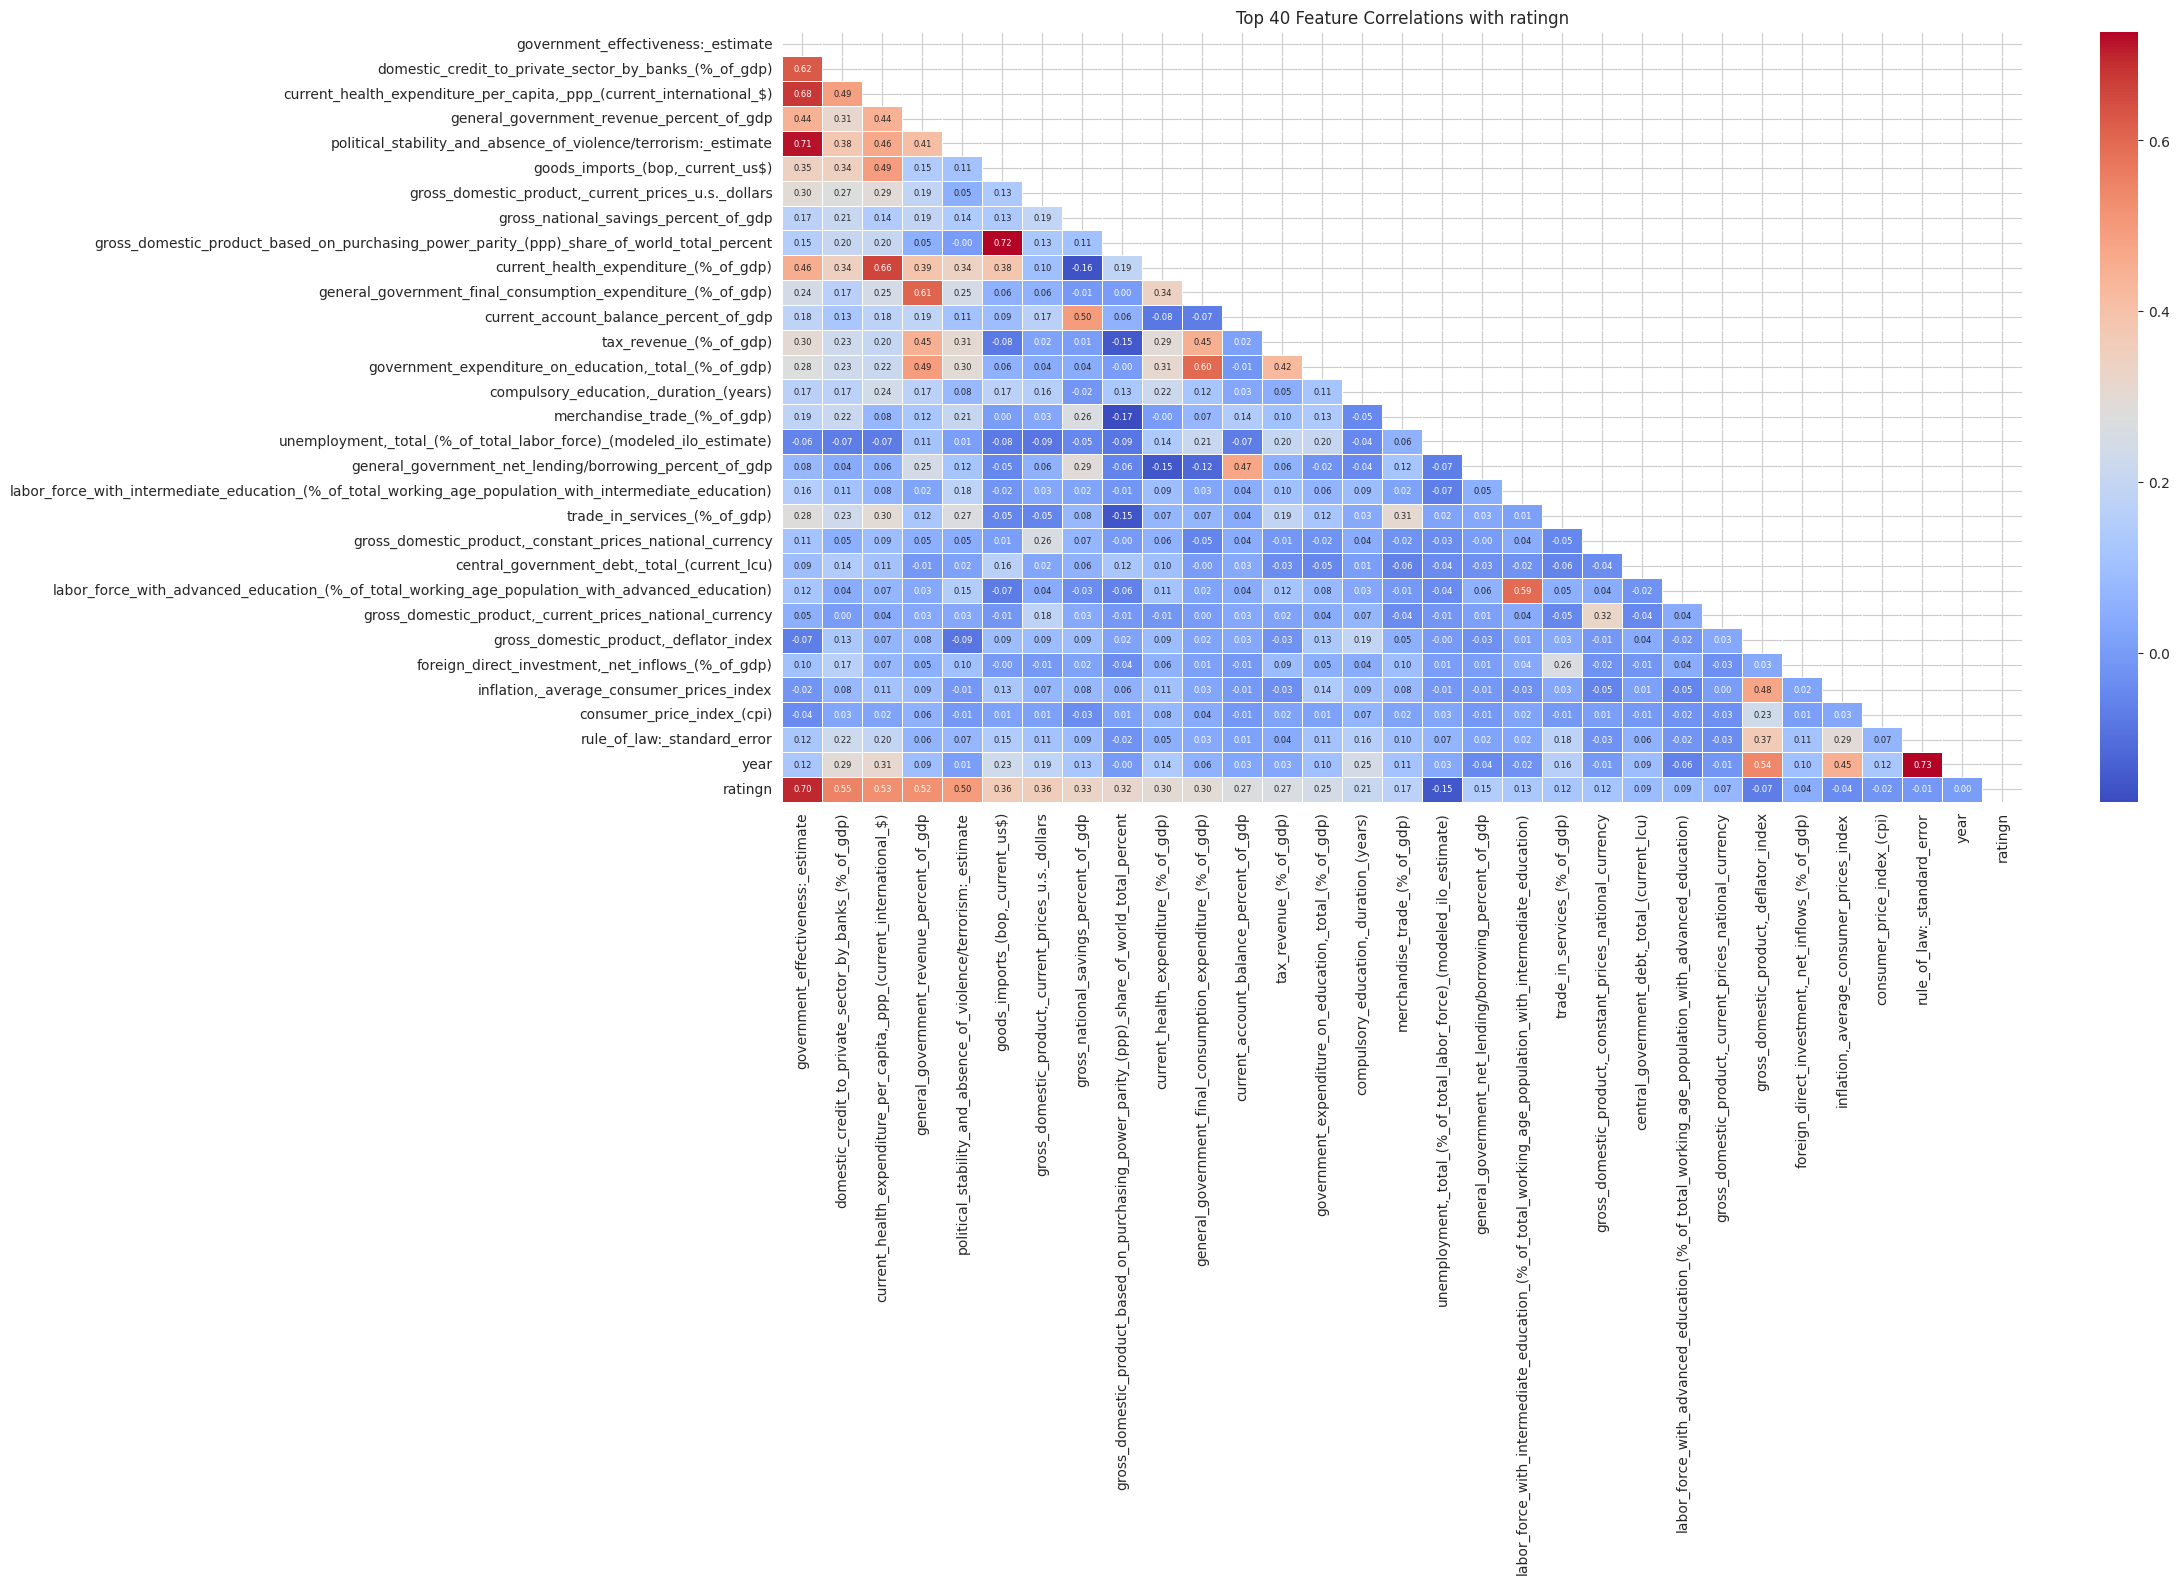

In [49]:
# Checking corelation with 'ratingn' for the top features
corr_matrix = dfc.corr(numeric_only=True)
target_corr = corr_matrix['ratingn'].abs().sort_values(ascending=False)

# Select the top 40 most correlated features to focus on
top_features = pd.Series(target_corr[1:41].index).drop_duplicates().tolist()

# Create a new DataFrame with only these features plus the target
df_subset = dfc[top_features + ['ratingn']]

# Plot the heatmap for the subset
plt.figure(figsize=(20, 10))
mask = np.triu(np.ones_like(df_subset.corr(), dtype=bool))
sns.heatmap(df_subset.corr(numeric_only=True), mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 6})
plt.title('Top 40 Feature Correlations with ratingn')
plt.show()

#### 3.3.1 Create Lagging features for Regression models (placeholder for future development)

In [50]:
# Future development

#### 3.4.1 Create Lagging features for Classification models (placeholder for future development)

In [51]:
# Create a new feature Rating + Outlook. In case the final result is not good enough.
# combined_order = [
#     'AAA-Positive',
#     'AAA-Stable',
#     'AAA-Negative',
#     'AA+-Positive',
#     'AA+-Stable',
#     'AA+-Negative',
#     'AA-Positive',
# ]

In [52]:
# Creating Outlook lagging feature (Outlook year-1 and year-2)

### 3.2 Regression models (future development - work in progress)

#### 3.2.1 Build the model dataframe

In [53]:
# Creating Classification dataframe
# Drop target columns for Classification model
#dfrg = dfc.copy().drop(['ratingn', 'outlook'], axis=1)

In [54]:
# # List of existing columns to create new ones
# columns_to_remove = ['country','year']
# existing_columns = dfrg.columns.difference(columns_to_remove).tolist()

# # Create a list of the new column names
# new_column_suffixes = ['current_year', 'next_year']

# # Loop through the existing columns to create the new ones
# for col in existing_columns:
#     for suffix in new_column_suffixes:
#         new_col_name = f'{col}_{suffix}'
#         dfrg[new_col_name] = np.nan

#### 3.2.2 Setting the Baseline Model accuracy for Regression Model

In [55]:
# # 1. Define the feature columns
# # I will use these columns as both features and shifted targets
# # I exclude non-numerical or non-feature columns
# historical_cols = [
#     col for col in dfrg.columns
#     if '_current_year' not in col and '_next_year' not in col
#     and col not in ['country', 'year']
# ]

# # Ensure DataFrame is sorted for correct shifting
# dfrg.sort_values(by=['country', 'year'], inplace=True)

# # 1. Prepare the Features (X) and Target (y)
# # Define the historical columns to be used as features and targets
# historical_cols = [
#     col for col in dfrg.columns
#     if '_current_year' not in col and '_next_year' not in col
#     and col not in ['country', 'year']
# ]

# # Create the target (y) by shifting the historical data
# y_target = dfrg.groupby('country')[historical_cols].shift(-1)
# X_features = dfrg[historical_cols]

# # Filter out the last year's data for each country where the target is NaN
# valid_data_indices = y_target.dropna().index
# X_baseline = X_features.loc[valid_data_indices]
# y_baseline = y_target.loc[valid_data_indices]


# # 1. Initialize a list to store all results
# all_results = []

# # 2. Set up the K-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# model = LinearRegression()

# # 3. Loop through each fold
# for train_index, test_index in kf.split(X_baseline):
#     # Split the data into training and test sets
#     X_train, X_test = X_baseline.iloc[train_index], X_baseline.iloc[test_index]
#     y_train, y_test = y_baseline.iloc[train_index], y_baseline.iloc[test_index]
    
#     # Get the country information for the test set
#     X_test_with_country = dfrg.loc[X_test.index, ['country']]
    
#     # Train the model on the training data
#     model.fit(X_train, y_train)
    
#     # Make predictions on the unseen test data
#     y_pred = model.predict(X_test)
#     y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=y_test.columns)

#     # 4. Calculate RMSE for each country and feature on the test set
#     for country in X_test_with_country['country'].unique():
#         country_test_indices = X_test_with_country[X_test_with_country['country'] == country].index
        
#         country_y_true = y_test.loc[country_test_indices]
#         country_y_pred = y_pred_df.loc[country_test_indices]
        
#         # Calculate RMSE for each feature for this country
#         for feature in country_y_true.columns:
#             y_true_series = country_y_true[feature]
#             y_pred_series = country_y_pred[feature]
            
#             # Only calculate RMSE if the series is not empty
#             if not y_true_series.empty:
#                 rmse = np.sqrt(mean_squared_error(y_true_series, y_pred_series))
#                 all_results.append({'country': country, 'feature': feature, 'rmse': rmse})

# # 5. Create and display a DataFrame of the aggregated results
# # Group by country and feature, then average the RMSE across all folds
# rmse_df = pd.DataFrame(all_results).groupby(['country', 'feature']).mean().reset_index()
# rmse_df = rmse_df.sort_values(by='rmse', ascending=False)

# print("="*65)
# print("RMSE per Country and Feature (Out-of-Sample):")
# print(rmse_df)
# print("="*65)

In [56]:
# # ARIMA non-optimized
# # Create a list to store the results
# arima_results = []
# skipped_series = 0

# # 2. Loop through each country and each historical feature with a progress bar
# for country in tqdm(dfrg['country'].unique()):
#     country_df = dfrg[dfrg['country'] == country].set_index('year')
    
#     for feature in historical_cols:
#         series = country_df[feature].dropna()
        
#         # We need a minimum number of points to fit an ARIMA model
#         if len(series) < 10:
#             skipped_series += 1
#             continue

#         # 3. Split the time series for training and testing
#         split_point = int(len(series) * 0.8)
#         train_series = series.iloc[:split_point]
#         test_series = series.iloc[split_point:]

#         # 4. Fit the ARIMA model
#         try:
#             model = ARIMA(train_series, order=(1, 1, 1))
#             model_fit = model.fit()

#             # 5. Make predictions on the test set
#             forecast = model_fit.predict(start=len(train_series), end=len(train_series) + len(test_series) - 1, typ='levels')
            
#             # 6. Calculate RMSE
#             rmse = np.sqrt(mean_squared_error(test_series, forecast))
#             arima_results.append({'country': country, 'feature': feature, 'rmse': rmse})
        
#         except Exception as e:
#             # If the model fails to fit, we'll skip this series
#             skipped_series += 1
#             continue

# # 7. Aggregate and display the results
# rmse_df = pd.DataFrame(arima_results).groupby(['country', 'feature']).mean().reset_index()
# rmse_df = rmse_df.sort_values(by='rmse', ascending=False)

# print("="*65)
# print("ARIMA RMSE per Country and Feature:")
# print(rmse_df)
# print(f"\nTotal series skipped due to insufficient data or model failure: {skipped_series}")
# print("="*65)

### 3.3 Classification Models

#### 3.3.1 Build the model dataframe

In [57]:
# Creating Classification dataframe
dfcl = dfc.copy()

# Creating train and target dataframes.
X = dfcl.drop(['ratingn','outlook', 'country'], axis=1) # Remove Country clumn becuase I need a general model rather than country based.
yr = dfcl['ratingn']   # Prediction for the country rating
yo = dfcl['outlook'] # Prediction for country outlook

In [58]:
# Instantiate the label encoder
le_yr = LabelEncoder()
le_yo = LabelEncoder()

# Fit and transform the targets
# At the end I will have to decode by using le_yr.inverse_transform() and le_yo.inverse_transform()
yr_encoded = le_yr.fit_transform(yr)
yo_encoded = le_yo.fit_transform(yo)

# Splitting data into training and testing sets. I have two targets country rating (yr) and country outlook (yo) 
X_train, X_test, yr_train, yr_test, yo_train, yo_test = train_test_split(X, yr_encoded, yo_encoded, test_size=0.2, random_state=42)

#### 3.3.2 Split dataset in Train and test datasets

#### 3.3.3 Define data Pre-Processor

In [59]:
# Treat year as categorical column although contains numerical values (int32). This is key!!!
# Defining the preprocessor
categorical_columns = X_train.select_dtypes(include=['object', 'int32']).columns.tolist() 
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

#### 3.3.4 Define the Baseline Model accuracy for Classification Model

In [60]:
# Defining the baseline model score. Create a shallow Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=40, random_state=42)

# Create a pipeline that first preprocesses the data and then runs the model
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_model)
])

# Use the pipeline with cross-validation for the 'ratingn' target
baseline_score_yr = cross_val_score(dt_pipeline, X_train, yr_train, cv=5, scoring='f1_macro')

# Use the pipeline with cross-validation for the 'outlookrank' target
baseline_score_yo = cross_val_score(dt_pipeline, X_train, yo_train, cv=5, scoring='f1_macro')

print("="*65)
print(f"Baseline F1-Score using a shallow Decision Tree for yr: {baseline_score_yr.mean():.4f}")
print(f"Baseline F1-Score using a shallow Decision Tree for yo: {baseline_score_yo.mean():.4f}")
print("="*65)

Baseline F1-Score using a shallow Decision Tree for yr: 0.5469
Baseline F1-Score using a shallow Decision Tree for yo: 0.5588


## 4. Experimentation

### 4.1 Regression Models

#### 4.1.1 Models set-up and experimentation (placeholder for future development)

In [61]:
# Future development

### 4.2 Classification Models

#### 4.2.1 Models set-up and experimentation for Country Ratings

Training Models:   0%|                                    | 0/5 [00:00<?, ?it/s]

Training RANDOMFOREST on the full data.


Training Models:  20%|█████▌                      | 1/5 [00:26<01:44, 26.14s/it]

Training XGBOOST on the full data.


Training Models:  40%|███████████▏                | 2/5 [01:26<02:19, 46.37s/it]

Training ADABOOST on the full data.


Training Models:  60%|████████████████▊           | 3/5 [01:59<01:20, 40.18s/it]

Training LIGHTGBM on the full data.


Training Models:  80%|█████████████████████▌     | 4/5 [37:46<14:31, 871.78s/it]

Training CATBOOST on the full data.


Training Models: 100%|███████████████████████████| 5/5 [39:58<00:00, 479.80s/it]


Feature Importances of the Best Model
num__government_effectiveness:_estimate                                                                         0.067707
num__gross_domestic_product_based_on_purchasing_power_parity_(ppp)_share_of_world_total_percent                 0.063153
num__compulsory_education,_duration_(years)                                                                     0.056624
num__goods_imports_(bop,_current_us$)                                                                           0.049040
num__gross_domestic_product,_constant_prices_national_currency                                                  0.044909
num__general_government_revenue_percent_of_gdp                                                                  0.041554
num__domestic_credit_to_private_sector_by_banks_(%_of_gdp)                                                      0.041239
num__unemployment,_total_(%_of_total_labor_force)_(modeled_ilo_estimate)                                        0.0

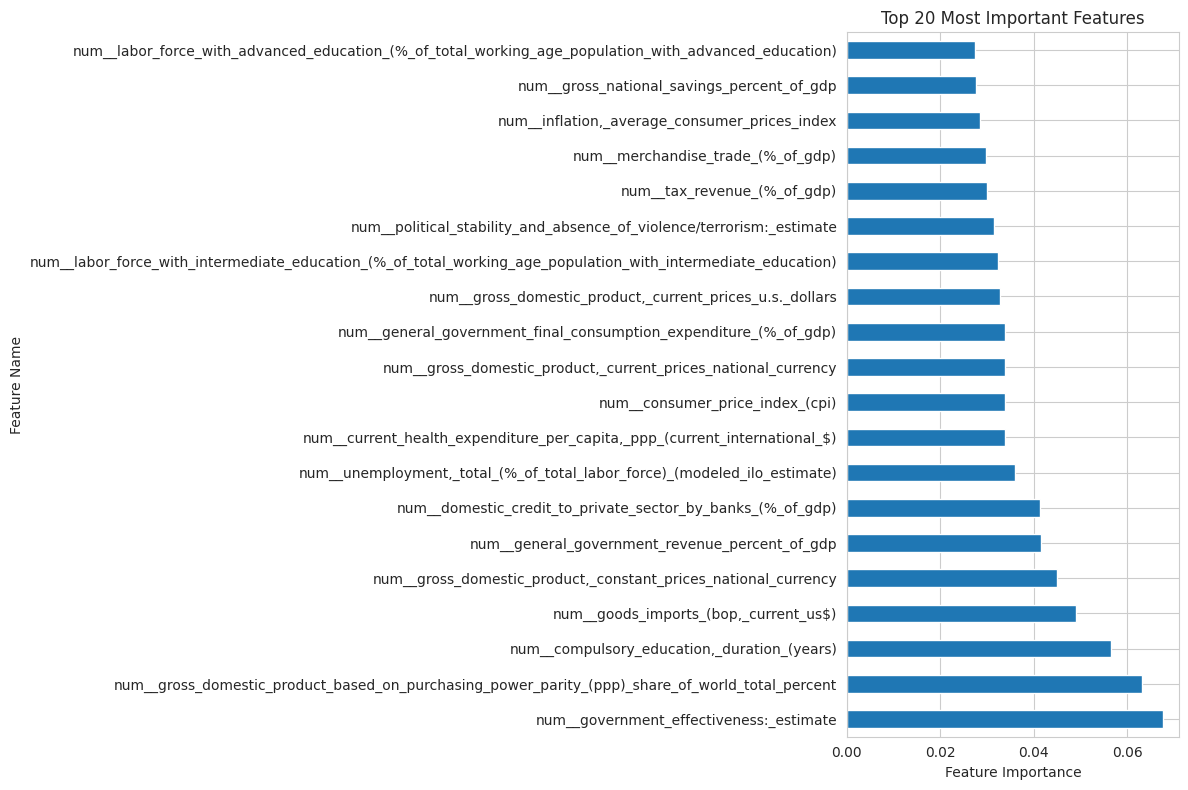

Multiclass Model Results


Overall Best Model and Parameters
Best Model: xgboost
Best Test Score: 78.35%
Best Parameters: {'xgboost__subsample': 0.8, 'xgboost__n_estimators': 100, 'xgboost__min_child_weight': 2, 'xgboost__max_depth': 10, 'xgboost__learning_rate': 0.1, 'xgboost__colsample_bytree': 0.5}


In [62]:
def get_processed_feature_names(preprocessor):
    """
    This function gets the feature names after preprocessing.
    """
    return preprocessor.get_feature_names_out()


# Defining the models and hyperparameters
best_overall_model_yr = None
best_overall_score_yr = 0.0
best_overall_params_yr = {}
best_model_for_final_eval_yr = None

models = {
    'randomforest': (RandomForestClassifier(class_weight='balanced', random_state=42),
                     {'randomforest__n_estimators': [100, 200, 300],
                      'randomforest__max_depth': [5, 7, 10],
                      'randomforest__min_samples_leaf': [1, 5, 10],
                      'randomforest__min_samples_split': [2, 5, 10]}),
    
    'xgboost': (XGBClassifier(random_state=42),
               {'xgboost__n_estimators': [100, 200, 300],
                'xgboost__learning_rate': [0.01, 0.1],
                'xgboost__max_depth': [5, 10, 15],
                'xgboost__min_child_weight':[2, 4, 6],
                'xgboost__subsample': [0.5, 0.8],
                'xgboost__colsample_bytree': [0.5, 0.8]}),

    'adaboost': (AdaBoostClassifier(random_state=42),
                {'adaboost__n_estimators': [200, 300, 500],
                 'adaboost__learning_rate': [0.01, 0.1, 1.0]}),
    
    'lightgbm': (LGBMClassifier(random_state=42, verbose=-1),
                {'lightgbm__n_estimators': [100, 200],
                 'lightgbm__num_leaves': [ 5, 10],
                 'lightgbm__learning_rate': [0.01, 0.1],
                 'lightgbm__max_depth': [6, 8],
                 'lightgbm__min_child_samples': [10, 15]
                }),
    
    'catboost': (CatBoostClassifier(random_state=42, verbose=0, early_stopping_rounds=50),
                 {'catboost__iterations': [100, 200],
                  'catboost__learning_rate': [0.01],
                  'catboost__depth': [4, 6],
                  'catboost__l2_leaf_reg': [3, 5]})
}

results = []
yr_pred_probas = {}

# Wrap the loop iterable with tqdm()
for name, (model, params) in tqdm(models.items(), desc="Training Models"):
    # --- Creating the pipeline ---
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    # I will select the best model based on F1-score
    f1_scorer = make_scorer(f1_score, average='macro')
    #grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring=f1_scorer)
    
    grid_search = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        n_iter=20, 
        cv=5,
        n_jobs=-1,
        scoring=f1_scorer,
        random_state=42
    )
    
    print(f"Training {name.upper()} on the full data.")
    start_time = time.time()
    
    grid_search.fit(X_train, yr_train)

    # Calculate the total duration for the entire grid search
    total_duration = time.time() - start_time
    fit_time = total_duration / len(grid_search.cv_results_['mean_fit_time'])
    
    best_model = grid_search.best_estimator_
    
    # --- Evaluate on preprocessed data ---
    train_score_yr = best_model.score(X_train, yr_train)
    test_score_yr = best_model.score(X_test, yr_test)
    
    if test_score_yr > best_overall_score_yr:
        best_overall_score_yr = test_score_yr
        best_overall_model_yr = name
        best_overall_params_yr = grid_search.best_params_
        best_model_for_final_eval_yr = best_model

    yr_pred = best_model.predict(X_test)
    
    # Calculate probabilities
    yr_pred_proba = best_model.predict_proba(X_test)
    
    # Store probabilities
    # For multiclass, ROC curve plotting needs to be handled differently (one-vs-rest)
    yr_pred_probas[name] = yr_pred_proba

    # Calculating metrics using the current predictions
    accuracy = accuracy_score(yr_test, yr_pred)
    recall = recall_score(yr_test, yr_pred, average='macro', zero_division=0)
    precision = precision_score(yr_test, yr_pred, average='macro', zero_division=0)
    f1 = f1_score(yr_test, yr_pred, average='macro', zero_division=0)

    # --- Metrics for the results DataFrame ---
    results.append([name, train_score_yr, test_score_yr, accuracy, recall, precision, f1, fit_time])

preprocessor_fitted = best_model_for_final_eval_yr.named_steps['preprocessor']
processed_feature_names = get_processed_feature_names(preprocessor_fitted)

# Access the best model from the fitted pipeline
best_classifier = best_model_for_final_eval_yr.named_steps[best_overall_model_yr]

# Check if the best classifier has the `feature_importances_` attribute
if hasattr(best_classifier, 'feature_importances_'):
    importances = best_classifier.feature_importances_

    # Create a pandas Series to easily view the importances with their corresponding names
    feature_importances_df = pd.Series(importances, index=processed_feature_names)

    # Sort the features by importance in descending order
    feature_importances_df = feature_importances_df.sort_values(ascending=False)

    # Print the top N most important features
    print("="*90)
    print("Feature Importances of the Best Model")
    print("="*90)
    print(feature_importances_df.head(20))

    # Visualize the feature importances with a bar chart
    plt.figure(figsize=(12, 8))
    feature_importances_df.head(20).plot(kind='barh')
    plt.title("Top 20 Most Important Features")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()

else:
    print("The best model does not have a 'feature_importances_' attribute.")
    print("This method is only applicable to tree-based models like RandomForest, XGBoost, and LightGBM.")

# Creating the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'accuracy', 'recall', 'precision', 'f1_score', 'average fit time'])
results_df.set_index('model', inplace=True)

# Saving the df for the final analysis
results_df_yr = results_df

print("="*90)
print("Multiclass Model Results")
print("="*90)

# Beautifying the DataFrame
styled_df_yr = (results_df_yr.style
    .background_gradient(cmap='Blues')
    .format({
        'train score': '{:.2%}',
        'test score': '{:.2%}',
        'accuracy': '{:.2%}',
        'recall': '{:.2%}',
        'precision': '{:.2%}',
        'f1_score': '{:.2%}',
        'average fit time': '{:.2f}s',
        'total duration': '{:.2f}s'
    })
    .highlight_max(subset=['test score', 'accuracy', 'recall', 'precision', 'f1_score'], axis=0, color='green')
    .set_caption("Model Performance Metrics")
)

display(styled_df_yr) 

print("="*90)
print("Overall Best Model and Parameters")
print("="*90)
print(f"Best Model: {best_overall_model_yr}")
print(f"Best Test Score: {best_overall_score_yr:.2%}")
print(f"Best Parameters: {best_overall_params_yr}")
print("="*90)

#### **Experiment conclusions:** 
- **XGBoost GBM** is the model that provided the best result.
- LightGBM it seems that is very computationally expensive. This is unexpected since it supossed to be computationally less expensive than XGBoost or CatBoost.

#### 4.2.2 Models set-up and experimentation for Country Outlook

Training Models:   0%|                                    | 0/5 [00:00<?, ?it/s]

Training RANDOMFOREST on the full data.


Training Models:  20%|█████▌                      | 1/5 [00:51<03:27, 51.96s/it]

Training XGBOOST on the full data.


Training Models:  40%|███████████▏                | 2/5 [01:52<02:50, 56.89s/it]

Training ADABOOST on the full data.


Training Models:  60%|████████████████▊           | 3/5 [02:04<01:12, 36.49s/it]

Training LIGHTGBM on the full data.


Training Models:  80%|█████████████████████▌     | 4/5 [07:22<02:27, 147.81s/it]

Training CATBOOST on the full data.


Training Models: 100%|████████████████████████████| 5/5 [08:00<00:00, 96.06s/it]


Feature Importances of the Best Model
num__gross_domestic_product_based_on_purchasing_power_parity_(ppp)_share_of_world_total_percent                 0.044148
num__gross_domestic_product,_constant_prices_national_currency                                                  0.042272
num__compulsory_education,_duration_(years)                                                                     0.040519
num__unemployment,_total_(%_of_total_labor_force)_(modeled_ilo_estimate)                                        0.040282
num__general_government_net_lending/borrowing_percent_of_gdp                                                    0.039889
num__goods_imports_(bop,_current_us$)                                                                           0.037190
num__labor_force_with_advanced_education_(%_of_total_working_age_population_with_advanced_education)            0.036923
num__domestic_credit_to_private_sector_by_banks_(%_of_gdp)                                                      0.0

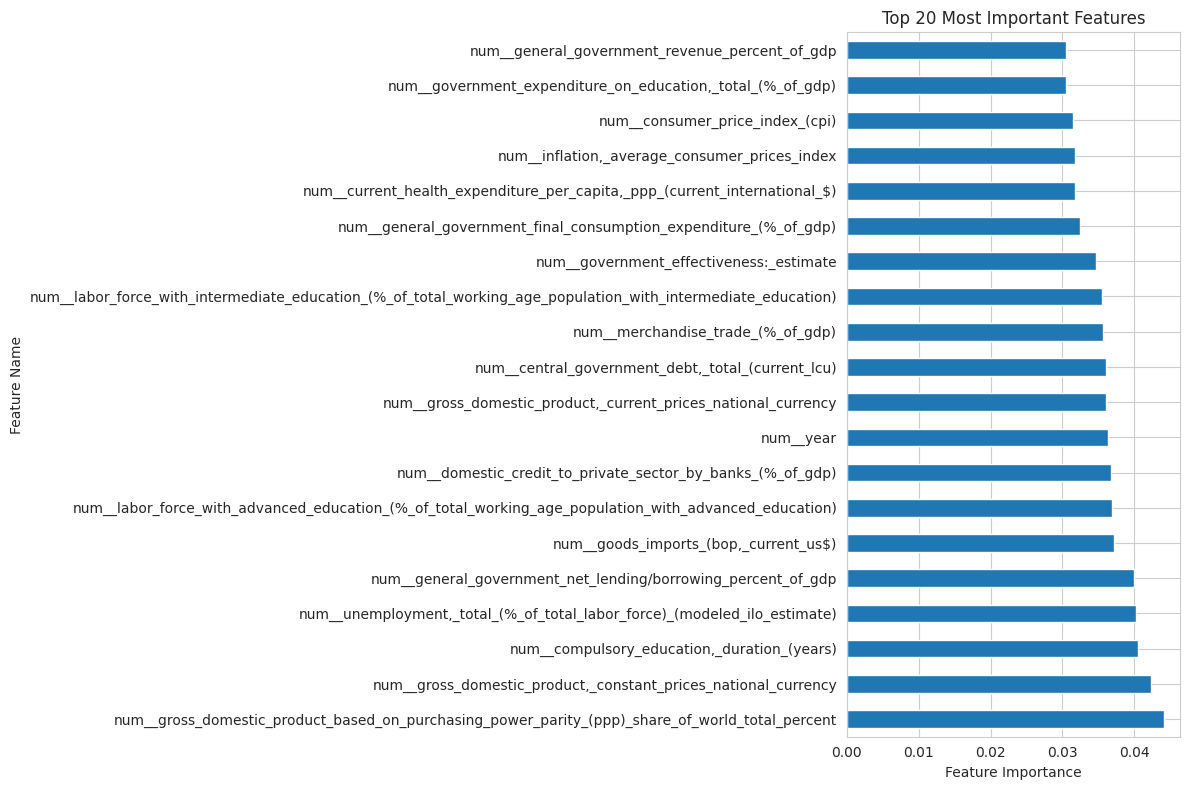

Multiclass Model Results


Overall Best Model and Parameters
Best Model: xgboost
Best Test Score: 83.50%
Best Parameters: {'xgboost__subsample': 0.8, 'xgboost__n_estimators': 300, 'xgboost__min_child_weight': 1, 'xgboost__max_depth': 15, 'xgboost__learning_rate': 0.1, 'xgboost__colsample_bytree': 0.5}


In [63]:
def get_processed_feature_names(preprocessor):
    """
    This function gets the feature names after preprocessing.
    """
    return preprocessor.get_feature_names_out()

# This line should be called after a pipeline with the preprocessor has been fit
# processed_feature_names = get_processed_feature_names(preprocessor_fitted)

# Defining the models and hyperparameters
best_overall_model_yo = None
best_overall_score_yo = 0.0
best_overall_params_yo = {}
best_model_for_final_eval_yo = None

models = {
    'randomforest': (RandomForestClassifier(class_weight='balanced', random_state=42),
                     {'randomforest__n_estimators': [300, 500],
                      'randomforest__max_depth': [7, 10, 15],
                      'randomforest__min_samples_leaf': [1, 5],
                      'randomforest__min_samples_split': [2, 5, 10]}),
    
    'xgboost': (XGBClassifier(random_state=42),
               {'xgboost__n_estimators': [200, 300],
                'xgboost__learning_rate': [0.01, 0.1],
                'xgboost__max_depth': [15],
                'xgboost__min_child_weight':[1, 3],
                'xgboost__subsample': [0.8],
                'xgboost__colsample_bytree': [0.5, 0.8]}),

    'adaboost': (AdaBoostClassifier(random_state=42),
                {'adaboost__n_estimators': [50, 100, 200],
                 'adaboost__learning_rate': [0.01, 0.1, 1.0]}),
    
    'lightgbm': (LGBMClassifier(random_state=42, verbose=-1),
                {'lightgbm__n_estimators': [100, 200],
                 'lightgbm__num_leaves': [ 5, 10],
                 'lightgbm__learning_rate': [0.01, 0.1],
                 'lightgbm__max_depth': [6, 8],
                 'lightgbm__min_child_samples': [10, 15]
                }),
    
    'catboost': (CatBoostClassifier(random_state=42, verbose=0, early_stopping_rounds=50),
                 {'catboost__iterations': [100, 200],
                  'catboost__learning_rate': [0.01],
                  'catboost__depth': [4, 6],
                  'catboost__l2_leaf_reg': [3, 5]})
}

results = []
yo_pred_probas = {}

# Wrap the loop iterable with tqdm()
for name, (model, params) in tqdm(models.items(), desc="Training Models"):
    # --- Creating the pipeline ---
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    # I will select the best model based on F1-score
    f1_scorer = make_scorer(f1_score, average='macro')
    #grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring=f1_scorer)
    
    grid_search = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        n_iter=20, 
        cv=5,
        n_jobs=-1,
        scoring=f1_scorer,
        random_state=42
    )
    
    print(f"Training {name.upper()} on the full data.")
    start_time = time.time()
    
    grid_search.fit(X_train, yo_train)

    # Calculate the total duration for the entire grid search
    total_duration = time.time() - start_time
    fit_time = total_duration / len(grid_search.cv_results_['mean_fit_time'])
    
    best_model = grid_search.best_estimator_
    
    # --- Evaluate on preprocessed data ---
    train_score_yo = best_model.score(X_train, yo_train)
    test_score_yo = best_model.score(X_test, yo_test)
    
    if test_score_yo > best_overall_score_yo:
        best_overall_score_yo = test_score_yo
        best_overall_model_yo = name
        best_overall_params_yo = grid_search.best_params_
        best_model_for_final_eval_yo = best_model

    yo_pred = best_model.predict(X_test)
    
    # Calculate probabilities
    yo_pred_proba = best_model.predict_proba(X_test)
    
    # Store probabilities
    # For multiclass, ROC curve plotting needs to be handled differently (one-vs-rest)
    yo_pred_probas[name] = yo_pred_proba

    # Calculating metrics using the current predictions
    accuracy = accuracy_score(yo_test, yo_pred)
    recall = recall_score(yo_test, yo_pred, average='macro', zero_division=0)
    precision = precision_score(yo_test, yo_pred, average='macro', zero_division=0)
    f1 = f1_score(yo_test, yo_pred, average='macro', zero_division=0)

    # --- Metrics for the results DataFrame ---
    results.append([name, train_score_yo, test_score_yo, accuracy, recall, precision, f1, fit_time])

preprocessor_fitted = best_model_for_final_eval_yo.named_steps['preprocessor']
processed_feature_names = get_processed_feature_names(preprocessor_fitted)

# Access the best model from the fitted pipeline
best_classifier = best_model_for_final_eval_yo.named_steps[best_overall_model_yo]

# Check if the best classifier has the `feature_importances_` attribute
if hasattr(best_classifier, 'feature_importances_'):
    importances = best_classifier.feature_importances_

    # Create a pandas Series to easily view the importances with their corresponding names
    feature_importances_df = pd.Series(importances, index=processed_feature_names)

    # Sort the features by importance in descending order
    feature_importances_df = feature_importances_df.sort_values(ascending=False)

    # Print the top N most important features
    print("="*90)
    print("Feature Importances of the Best Model")
    print("="*90)
    print(feature_importances_df.head(20))

    # Visualize the feature importances with a bar chart
    plt.figure(figsize=(12, 8))
    feature_importances_df.head(20).plot(kind='barh')
    plt.title("Top 20 Most Important Features")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()

else:
    print("The best model does not have a 'feature_importances_' attribute.")
    print("This method is only applicable to tree-based models like RandomForest, XGBoost, and LightGBM.")

# Creating the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'accuracy', 'recall', 'precision', 'f1_score', 'average fit time'])
results_df.set_index('model', inplace=True)

# Saving the df for the final analysis
results_df_yo = results_df

print("="*90)
print("Multiclass Model Results")
print("="*90)

# Beautifying the DataFrame
styled_df_yo = (results_df_yo.style
    .background_gradient(cmap='Blues')
    .format({
        'train score': '{:.2%}',
        'test score': '{:.2%}',
        'accuracy': '{:.2%}',
        'recall': '{:.2%}',
        'precision': '{:.2%}',
        'f1_score': '{:.2%}',
        'average fit time': '{:.2f}s',
        'total duration': '{:.2f}s'
    })
    .highlight_max(subset=['test score', 'accuracy', 'recall', 'precision', 'f1_score'], axis=0, color='green')
    .set_caption("Model Performance Metrics")
)

display(styled_df_yo)

print("="*90)
print("Overall Best Model and Parameters")
print("="*90)
print(f"Best Model: {best_overall_model_yo}")
print(f"Best Test Score: {best_overall_score_yo:.2%}")
print(f"Best Parameters: {best_overall_params_yo}")
print("="*90)

#### **Experiment conclusions:** 
- **XGBoost** is the model that provided the best result. However, Random forest model might sldo be considered. Additional analysis should be conducted at per class level.
- **LightGBM** it seems that is very computationally expensive. This is unexpected since it supossed to be computationally less expensive than XGBoost or CatBoost.

## 5. Evaluation

#### 5.1 Country Rating results evaluation

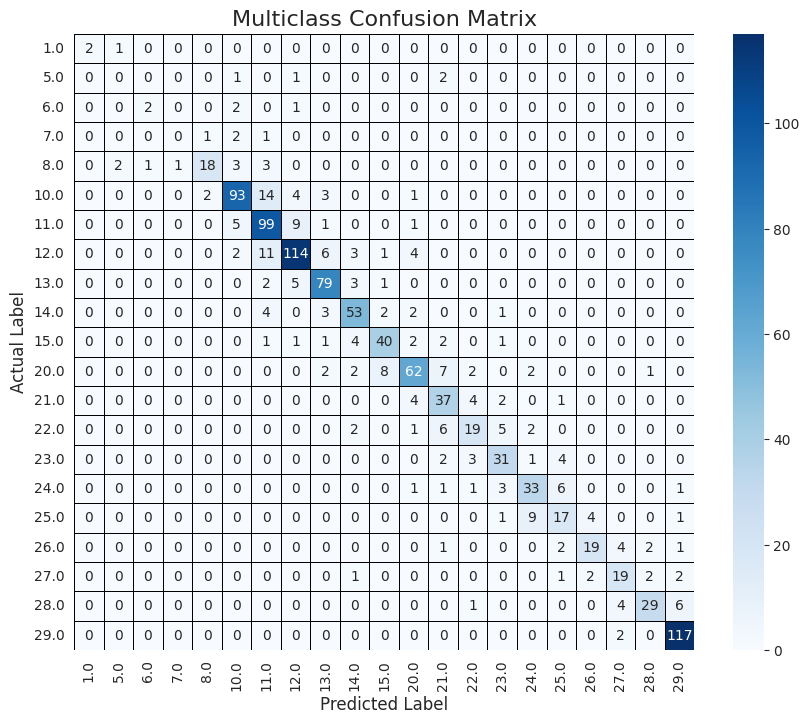

In [64]:
# Step 1: Get predictions from the best model
yr_pred_best = best_model_for_final_eval_yr.predict(X_test)

# Step 2: Create the multiclass confusion matrix
cm_yr = confusion_matrix(yr_test, yr_pred_best)

# Gt the class labels for the DataFrame
class_labels = le_yr.classes_

# Create a DataFrame for the confusion matrix with proper labels
cm_yr_df = pd.DataFrame(cm_yr, index=class_labels, columns=class_labels)

# Step 3: Create a heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm_yr_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.5, linecolor='black')
plt.title('Multiclass Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# Step 4: Get and display the classification report
report_dict = classification_report(yr_test, yr_pred_best, output_dict=True, zero_division=0)
report_yr_df = pd.DataFrame(report_dict).transpose()

# Format and display the styled DataFrame
styled_report_yr = (report_yr_df.style
    .format({'precision': '{:.2%}',
             'recall': '{:.2%}',
             'f1-score': '{:.2%}',
             'support': '{:.0f}'})
    .background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])
    .set_caption("Classification Report")
)

print("="*100)

display(styled_report_yr)

In [65]:
# Build ROC AUC curve for yr

# Binarize labels for ROC curve
classes = np.unique(yr_test)
n_classes = len(classes)

# Ensure yr_test is binarized
yr_test_binarized = label_binarize(yr_test, classes=classes)

# Choose the best model's predicted probabilities
yr_score = yr_pred_probas[best_overall_model_yr]

# Compute ROC AUC (macro average)
roc_auc = roc_auc_score(yr_test_binarized, yr_score, average='macro', multi_class='ovr')

print("="*50)
print(f"Multiclass ROC AUC Score (macro average): {roc_auc:.4f}")
print("="*50)

Multiclass ROC AUC Score (macro average): 0.9794


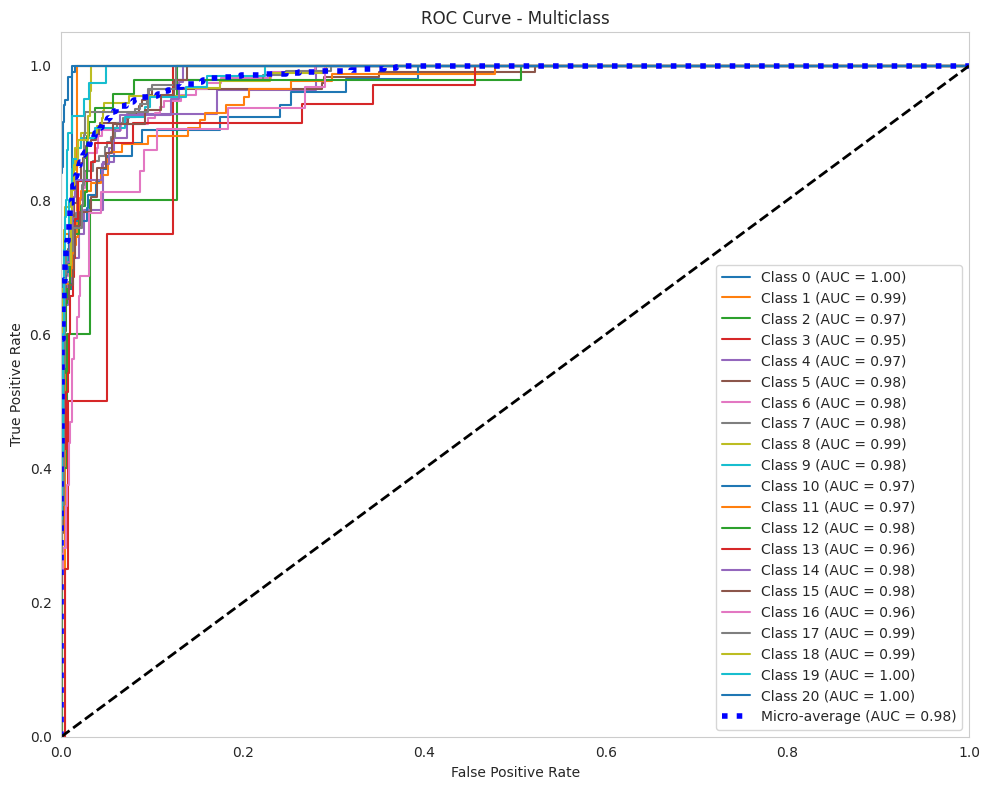

In [66]:
# 1. Initialize dictionaries to store results
fpr = dict()
tpr = dict()
roc_auc = dict()

# 2. Compute ROC curve and ROC area for EACH class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yr_test_binarized[:, i], yr_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yr_test_binarized.ravel(), yr_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot each class's curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the micro-average curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
         color='blue', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

#### 5.2 Country Outlook results evaluation

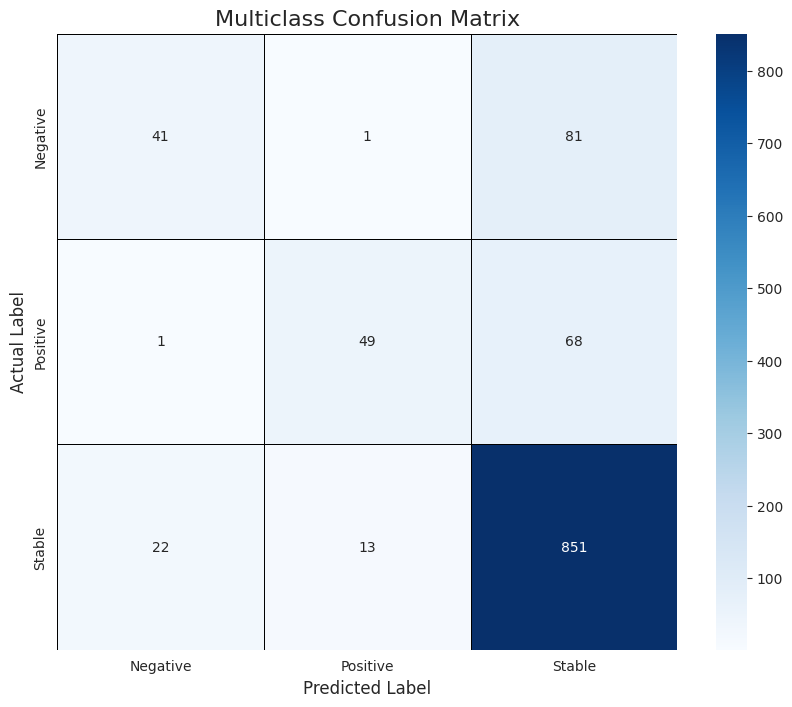

In [67]:
# Step 1: Get predictions from the best model
yo_pred_best = best_model_for_final_eval_yo.predict(X_test)

# Step 2: Create the multiclass confusion matrix
cm_yo = confusion_matrix(yo_test, yo_pred_best)

# Get the class labels for the DataFrame
class_labels = le_yo.classes_

# Create a DataFrame for the confusion matrix with proper labels
cm_yo_df = pd.DataFrame(cm_yo, index=class_labels, columns=class_labels)

# Step 3: Create a heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm_yo_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.5, linecolor='black')
plt.title('Multiclass Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# Step 4: Get and display the classification report
report_dict = classification_report(yo_test, yo_pred_best, output_dict=True, zero_division=0)
report_yo_df = pd.DataFrame(report_dict).transpose()

# Format and display the styled DataFrame
styled_report_yo = (report_yo_df.style
    .format({'precision': '{:.2%}',
             'recall': '{:.2%}',
             'f1-score': '{:.2%}',
             'support': '{:.0f}'})
    .background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])
    .set_caption("Classification Report")
)

print("="*100)

display(styled_report_yo)

In [68]:
# Build ROC AUC curve for yo

# Binarize labels for ROC curve
classes = np.unique(yo_test)
n_classes = len(classes)

# Ensure yo_test is binarized
yo_test_binarized = label_binarize(yo_test, classes=classes)

# Choose the best model's predicted probabilities
yo_score = yo_pred_probas[best_overall_model_yo]

# Compute ROC AUC (macro average)
roc_auc = roc_auc_score(yo_test_binarized, yo_score, average='macro', multi_class='ovr')

print("="*50)
print(f"Multiclass ROC AUC Score (macro average): {roc_auc:.4f}")
print("="*50)

Multiclass ROC AUC Score (macro average): 0.8761


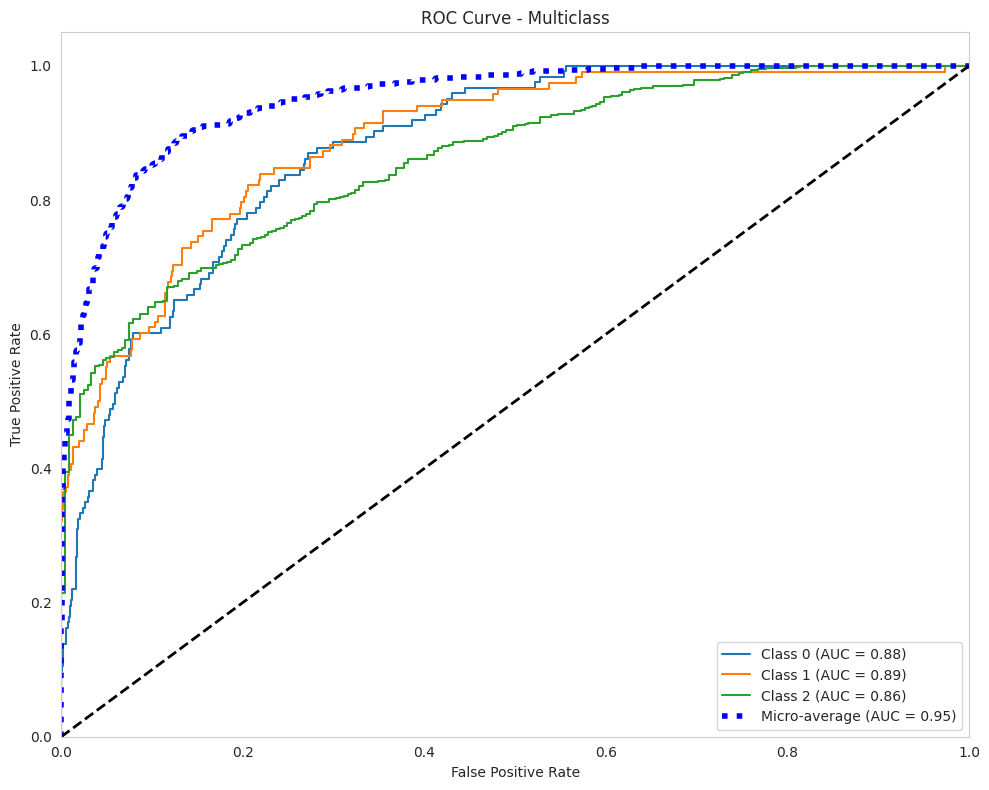

In [69]:
# 1. Initialize dictionaries to store results
fpr = dict()
tpr = dict()
roc_auc = dict()

# 2. Compute ROC curve and ROC area for EACH class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yo_test_binarized[:, i], yo_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yo_test_binarized.ravel(), yo_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot each class's curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the micro-average curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
         color='blue', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

In [70]:
notebook_end_time = time.time()
notebook_elapsed_time = notebook_end_time - notebook_start_time
print("="*40)
print(f"Total Elapsed time : {notebook_elapsed_time/60:.2f} Minutes")
print("="*40)

Total Elapsed time : 49.09 Minutes


## 6. Deployment

In [71]:
# Inverse transform the LabelEncoder to get back to the ratingn values
yr_pred_best_ratingn = le_yr.inverse_transform(yr_pred_best)
print(yr_pred_best_ratingn)

[10. 29. 20. ... 20.  8. 13.]


In [72]:
# Inverse transform the LabelEncoder to get back to the outlook values
yo_pred_best_outlook = le_yo.inverse_transform(yo_pred_best)
print(yo_pred_best_outlook)

['Stable' 'Negative' 'Stable' ... 'Positive' 'Stable' 'Stable']


## 7. Nest Steps for improvement 